### Imports

In [2]:
import csv
import re
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import datetime as dt

In [3]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

In [4]:
file = data_folder / "Diarios_final.feather"
evento = pd.read_feather(file)
evento.rename(columns = {"data_do_incidente":"date"}, inplace=True)

In [5]:
evento.columns

Index(['concelho', 'distrito', 'date', 't_med', 't_max', 't_min', 'dd_med',
       'dd_ffx', 'ff_med', 'ff_max', 'pr_qtd', 'dd_med_sin', 'dd_med_cos',
       'dd_ffx_sin', 'dd_ffx_cos', 'sen_ano', 'cos_ano', 'sen_mes', 'cos_mes',
       'densidade_populacional', 'populacao_residente', 'setor_primario',
       'setor_secundario', 'setor_terciario', 'indice_de_envelhecimento',
       'rural', 'count_zonaa', 'count_zonab', 'count_zonac',
       'total_concelho_zonas', 'percentagem_zonaa', 'percentagem_zonab',
       'percentagem_zonac', 'soma_degree_rede_concelho',
       'n_subestacoes_concelho', 'perc_prim', 'perc_sec', 'perc_terc',
       'minheight', 'maxheight'],
      dtype='object')

In [6]:
evento["cos_mes"].unique()

array([ 9.79529941e-01,  9.18957812e-01,  8.20763441e-01,  6.88966919e-01,
        5.28964010e-01,  3.47305253e-01,  1.51427778e-01, -5.06491688e-02,
       -2.50652532e-01, -4.40394152e-01, -6.12105983e-01, -7.58758123e-01,
       -8.74346616e-01, -9.54139256e-01, -9.94869323e-01, -9.94869323e-01,
       -8.74346616e-01, -7.58758123e-01, -6.12105983e-01, -4.40394152e-01,
       -2.50652532e-01, -5.06491688e-02,  1.51427778e-01,  6.88966919e-01,
        9.79529941e-01,  1.00000000e+00,  9.74927912e-01,  9.00968868e-01,
        7.81831482e-01,  6.23489802e-01,  4.33883739e-01,  2.22520934e-01,
        6.12323400e-17, -2.22520934e-01, -4.33883739e-01, -6.23489802e-01,
       -7.81831482e-01, -9.00968868e-01, -9.74927912e-01, -1.00000000e+00,
       -9.00968868e-01, -7.81831482e-01, -6.23489802e-01, -4.33883739e-01,
       -2.22520934e-01, -1.83697020e-16,  2.22520934e-01,  4.33883739e-01,
        6.23489802e-01,  7.81831482e-01,  9.00968868e-01,  9.74927912e-01,
        9.78147601e-01,  

In [7]:
evento["ano"] = evento["date"].dt.year
evento["mes"] = evento["date"].dt.month
evento["dia"] = evento["date"].dt.day

eventoTeste = evento[(evento["ano"] == 2022)]
eventoTeste = eventoTeste[['sen_mes', 'cos_mes', 'mes', 'dia']]
eventoTeste = eventoTeste.drop_duplicates(subset=['sen_mes', 'cos_mes', 'mes', 'dia'])
eventoTeste = eventoTeste.reset_index(drop=True)
eventoTeste

sen_mes   cos_mes  mes  dia
0    2.012985e-01  0.979530    1    1
1    3.943559e-01  0.918958    1    2
2    5.712682e-01  0.820763    1    3
3    7.247928e-01  0.688967    1    4
4    8.486443e-01  0.528964    1    5
..            ...       ...  ...  ...
360 -7.247928e-01  0.688967   12   27
361 -5.712682e-01  0.820763   12   28
362 -3.943559e-01  0.918958   12   29
363 -2.012985e-01  0.979530   12   30
364 -2.449294e-16  1.000000   12   31

[365 rows x 4 columns]

In [8]:
evento["cos_mes"].unique()

array([ 9.79529941e-01,  9.18957812e-01,  8.20763441e-01,  6.88966919e-01,
        5.28964010e-01,  3.47305253e-01,  1.51427778e-01, -5.06491688e-02,
       -2.50652532e-01, -4.40394152e-01, -6.12105983e-01, -7.58758123e-01,
       -8.74346616e-01, -9.54139256e-01, -9.94869323e-01, -9.94869323e-01,
       -8.74346616e-01, -7.58758123e-01, -6.12105983e-01, -4.40394152e-01,
       -2.50652532e-01, -5.06491688e-02,  1.51427778e-01,  6.88966919e-01,
        9.79529941e-01,  1.00000000e+00,  9.74927912e-01,  9.00968868e-01,
        7.81831482e-01,  6.23489802e-01,  4.33883739e-01,  2.22520934e-01,
        6.12323400e-17, -2.22520934e-01, -4.33883739e-01, -6.23489802e-01,
       -7.81831482e-01, -9.00968868e-01, -9.74927912e-01, -1.00000000e+00,
       -9.00968868e-01, -7.81831482e-01, -6.23489802e-01, -4.33883739e-01,
       -2.22520934e-01, -1.83697020e-16,  2.22520934e-01,  4.33883739e-01,
        6.23489802e-01,  7.81831482e-01,  9.00968868e-01,  9.74927912e-01,
        9.78147601e-01,  

C:\Users\diogo\AppData\Local\Temp\ipykernel_10936\1102190072.py:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=meses, label='Mês')


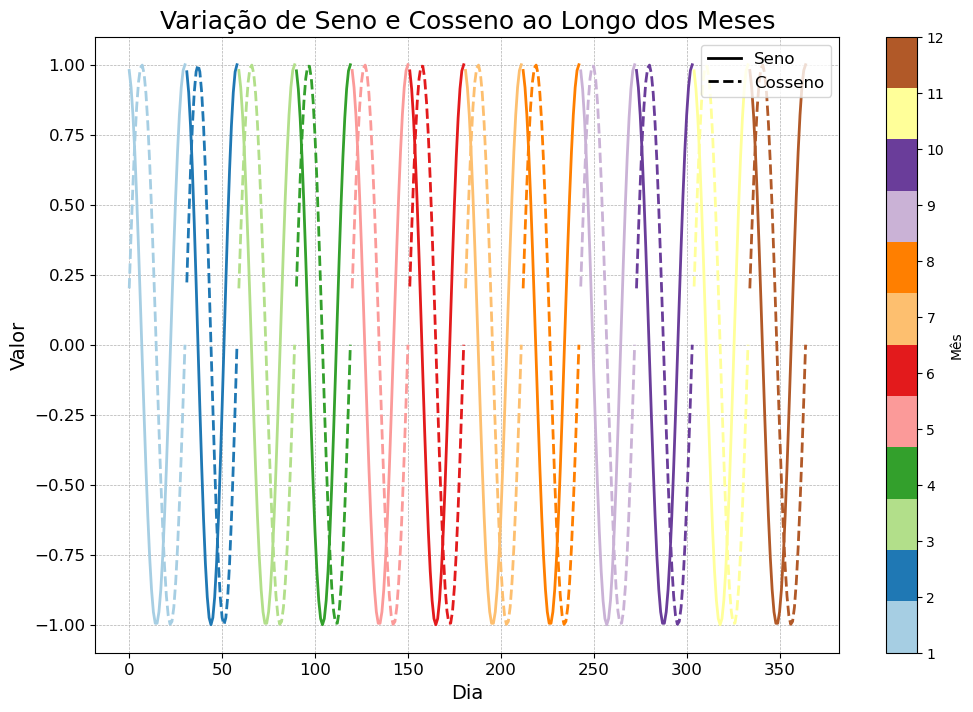

In [24]:
import calendar

def numero_para_mes(numero):
    # Verifica se o número está dentro do intervalo válido para meses (1 a 12)
    if 1 <= numero <= 12:
        # Usa o método .month_name para obter o nome completo do mês em inglês
        nome_mes = calendar.month_name[numero]
        # Ajusta o nome do mês para a abreviatura de três letras
        nome_mes_abreviado = nome_mes[:3].capitalize()
        return nome_mes_abreviado
    else:
        return "Número de mês inválido"

# Dados de exemplo (substitua com os dados reais de eventoTeste)
meses = eventoTeste['mes'].unique()  # Obtém os meses únicos presentes em eventoTeste

# Configurações visuais
plt.figure(figsize=(12, 8))

# Criando um mapa de cores para os meses
cores = plt.cm.Paired(np.linspace(0, 1, len(meses)))

# Plotagem dos dados de seno e cosseno para cada mês
for i, mes in enumerate(meses):
    dados_mes = eventoTeste[eventoTeste['mes'] == mes]
    plt.plot(dados_mes.index, dados_mes['sen_mes'], color=cores[i], linestyle='--', linewidth=2)
    plt.plot(dados_mes.index, dados_mes['cos_mes'], color=cores[i], linestyle='-', linewidth=2)

# Adicionar labels para seno e cosseno em preto
plt.plot([], [], color='k', linestyle='-', linewidth=2, label='Seno')
plt.plot([], [], color='k', linestyle='--', linewidth=2, label='Cosseno')

# Personalização do gráfico
plt.title('Variação de Seno e Cosseno ao Longo dos Meses', fontsize=18)
plt.xlabel('Dia', fontsize=14)
plt.ylabel('Valor', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', linewidth=0.5)

# Adicionando barra de cores para representar os meses
sm = plt.cm.ScalarMappable(cmap=plt.cm.Paired, norm=plt.Normalize(vmin=min(meses), vmax=max(meses)))
sm.set_array([])
plt.colorbar(sm, ticks=meses, label='Mês')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


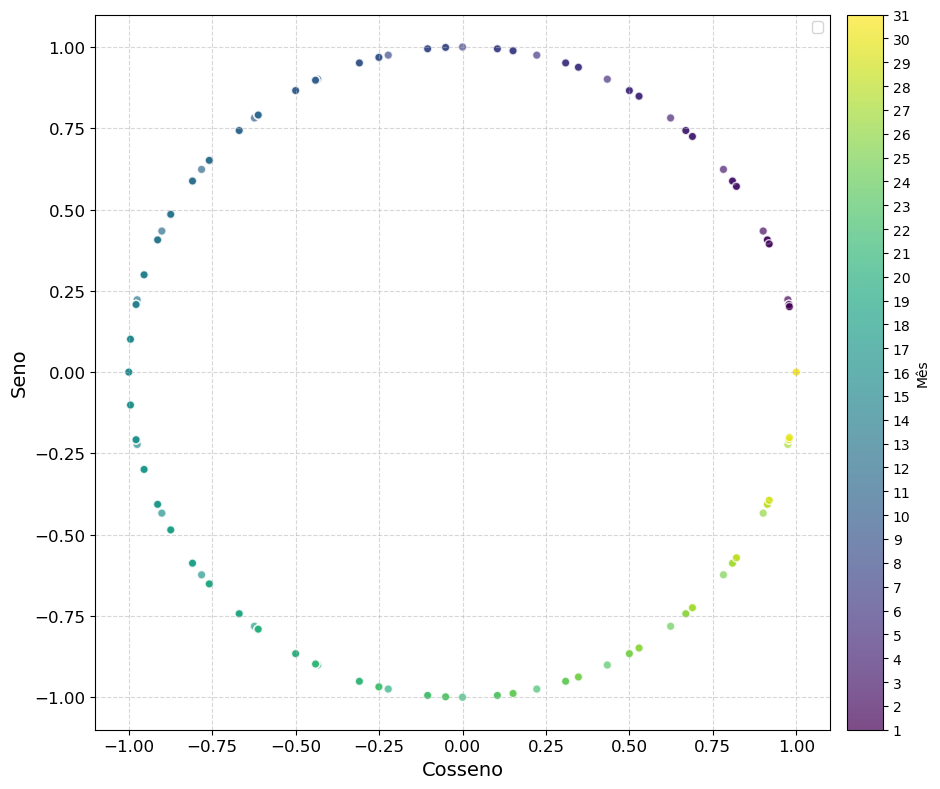

In [21]:
# Plotar o scatterplot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(eventoTeste['cos_mes'], eventoTeste['sen_mes'], c=eventoTeste['dia'], cmap='viridis', alpha=0.7, edgecolors='w')
plt.xlabel('Cosseno', fontsize=14)
plt.ylabel('Seno', fontsize=14)
plt.colorbar(scatter, label='Mês', ticks=range(1, 32), pad=0.02)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


## Leitura do ficheiro -- OLD

In [17]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

In [18]:
file = data_folder / "QuebrasJuntoInc.xlsx"
QuebrasFinal = pd.read_excel(file)
QuebrasFinal

Código do Relatório                Concelho Data do incidente  \
0       EDPD_2018_JAN_T_1                  Almada        2018-01-02   
1       EDPD_2018_JAN_T_2                   Sertã        2018-01-02   
2       EDPD_2018_JAN_T_3              Felgueiras        2018-01-04   
3       EDPD_2018_JAN_T_4           Torres Vedras        2018-01-05   
4       EDPD_2018_JAN_T_5                    Nisa        2018-01-09   
...                   ...                     ...               ...   
7300   EDPD_2017_NOV_T_62                    Ovar        2017-11-29   
7301   EDPD_2017_NOV_T_63    Santa Maria Da Feira        2017-11-03   
7302   EDPD_2017_NOV_T_64    Santa Maria Da Feira        2017-11-23   
7303   EDPD_2017_NOV_T_65                Almeirim        2017-11-03   
7304  IGI_2017_DEZ_TC_001  Vila Nova De Famalicão        2017-12-10   

     Nível de Tensão             Causa do incidente Duração incidente (min)  \
0                 MT                     Escavações                      55   
1                 MT               Abate De Árvores                     163   
2                 MT         Deslizamento De Terras                     596   
3                 BT                       Veículos                     178   
4                 MT                           Aves                     119   
...              ...                            ...                     ...   
7300              BT                       Veículos                     220   
7301              BT                       Veículos                      92   
7302              BT                       Veículos                     121   
7303              BT   Descarga Atmosférica Directa                     154   
7304      AT, MT, BT  Vento Intensidade Excepcional                    2440   

      N.º clientes afetados TIEPI MT (min) SAIFI MT (#) SAIDI MT (min)  ...  \
0                     828.0      0,0029345    0,0000443      0,0024563  ...   
1                     549.0      0,0029335    0,0001770      0,0165009  ...   
2                    3459.0      0,0192281    0,0002655      0,0359047  ...   
3                     102.0      0,0000000    0,0000000      0,0000000  ...   
4                    1731.0      0,0044221    0,0001549      0,0100377  ...   
...                     ...            ...          ...            ...  ...   
7300                    2.0              0            0              0  ...   
7301                    1.0              0            0              0  ...   
7302                    1.0              0            0              0  ...   
7303                    1.0              0            0              0  ...   
7304              1058005.0         17,100        0,330         29,300  ...   

     Indice de Envelhecimento     Rural T_MED T_MAX T_MIN DD_MED DD_FFX  \
0                       157.9  0.000000  10.7  17.4   2.6    NaN    NaN   
1                       260.2  1.000000  10.6  13.8   6.2  249.0  270.0   
2                       117.9  0.800000  14.0  14.8  12.9  197.0  180.0   
3                       156.4  0.923077  12.4  15.1   9.1  288.0  225.0   
4                       467.9  1.000000   4.9   7.8   2.2  137.0  118.0   
...                       ...       ...   ...   ...   ...    ...    ...   
7300                    141.7  1.000000  10.3  14.3   6.3    NaN    NaN   
7301                    134.6  0.000000  16.4  20.6  14.8    NaN    NaN   
7302                    134.6  0.000000  17.9  22.6  14.6    NaN    NaN   
7303                    175.1  1.000000  15.0  20.8  12.8  186.0  186.0   
7304                    124.3  0.794118  14.4  15.8  10.2  231.0  225.0   

      FF_MED  FF_MAX  PR_QTD  
0        NaN     NaN     0.0  
1        2.8     8.1     0.0  
2        3.9    14.4     4.0  
3        3.6    13.9    13.2  
4        4.1    15.4    15.9  
...      ...     ...     ...  
7300     NaN     NaN     0.0  
7301     NaN     NaN     NaN  
7302     NaN     NaN     8.1  
7303     2.5    11.0     NaN  
7304     NaN 

In [19]:
# Colocar datetime
QuebrasFinal["Data do incidente"] = pd.to_datetime(QuebrasFinal["Data do incidente"])

# Remover colunas desnecessárias
columnsRemove = ['Qualidade de Energia Elétrica', 'Qualidade de Serviço Comercial', 'Fundamentação']
QuebrasFinal = QuebrasFinal.drop(columns=columnsRemove)

# Substituir as vírgulas por pontos nas colunas supostamente numéricas
colunas_string = QuebrasFinal.iloc[:, 5:33].select_dtypes(include=['object']).columns
QuebrasFinal[colunas_string] = QuebrasFinal[colunas_string].replace(',', '.', regex=True)

QuebrasFinal

Código do Relatório                Concelho Data do incidente  \
0       EDPD_2018_JAN_T_1                  Almada        2018-01-02   
1       EDPD_2018_JAN_T_2                   Sertã        2018-01-02   
2       EDPD_2018_JAN_T_3              Felgueiras        2018-01-04   
3       EDPD_2018_JAN_T_4           Torres Vedras        2018-01-05   
4       EDPD_2018_JAN_T_5                    Nisa        2018-01-09   
...                   ...                     ...               ...   
7300   EDPD_2017_NOV_T_62                    Ovar        2017-11-29   
7301   EDPD_2017_NOV_T_63    Santa Maria Da Feira        2017-11-03   
7302   EDPD_2017_NOV_T_64    Santa Maria Da Feira        2017-11-23   
7303   EDPD_2017_NOV_T_65                Almeirim        2017-11-03   
7304  IGI_2017_DEZ_TC_001  Vila Nova De Famalicão        2017-12-10   

     Nível de Tensão             Causa do incidente Duração incidente (min)  \
0                 MT                     Escavações                      55   
1                 MT               Abate De Árvores                     163   
2                 MT         Deslizamento De Terras                     596   
3                 BT                       Veículos                     178   
4                 MT                           Aves                     119   
...              ...                            ...                     ...   
7300              BT                       Veículos                     220   
7301              BT                       Veículos                      92   
7302              BT                       Veículos                     121   
7303              BT   Descarga Atmosférica Directa                     154   
7304      AT, MT, BT  Vento Intensidade Excepcional                    2440   

      N.º clientes afetados TIEPI MT (min) SAIFI MT (#) SAIDI MT (min)  ...  \
0                     828.0      0.0029345    0.0000443      0.0024563  ...   
1                     549.0      0.0029335    0.0001770      0.0165009  ...   
2                    3459.0      0.0192281    0.0002655      0.0359047  ...   
3                     102.0      0.0000000    0.0000000      0.0000000  ...   
4                    1731.0      0.0044221    0.0001549      0.0100377  ...   
...                     ...            ...          ...            ...  ...   
7300                    2.0              0            0              0  ...   
7301                    1.0              0            0              0  ...   
7302                    1.0              0            0              0  ...   
7303                    1.0              0            0              0  ...   
7304              1058005.0         17.100        0.330         29.300  ...   

     Indice de Envelhecimento     Rural T_MED T_MAX  T_MIN  DD_MED  DD_FFX  \
0                       157.9  0.000000  10.7  17.4    2.6     NaN     NaN   
1                       260.2  1.000000  10.6  13.8    6.2   249.0   270.0   
2                       117.9  0.800000  14.0  14.8   12.9   197.0   180.0   
3                       156.4  0.923077  12.4  15.1    9.1   288.0   225.0   
4                       467.9  1.000000   4.9   7.8    2.2   137.0   118.0   
...                       ...       ...   ...   ...    ...     ...     ...   
7300                    141.7  1.000000  10.3  14.3    6.3     NaN     NaN   
7301                    134.6  0.000000  16.4  20.6   14.8     NaN     NaN   
7302                    134.6  0.000000  17.9  22.6   14.6     NaN     NaN   
7303                    175.1  1.000000  15.0  20.8   12.8   186.0   186.0   
7304                    124.3  0.794118  14.4  15.8   10.2   231.0   225.0   

     FF_MED  FF_MAX  PR_QTD  
0       NaN     NaN     0.0  
1       2.8     8.1     0.0  
2       3.9    14.4     4.0  
3       3.6    13.9    13.2  
4       4.1    15.4    15.9  
...     ...     ...     ...  
7300    NaN     NaN     0.0  
7301    NaN     NaN     NaN  
7302    NaN     NaN     8.1  
7303    2.5    11.

In [22]:
TT = ""
while (TT != "BT") and (TT != "MT"):
    TT = input("Queres que tipo de Tensão? (BT, MT)")
    print(TT)

QuebrasFinal = QuebrasFinal[QuebrasFinal["Nível de Tensão"] == TT]
QuebrasFinal.drop("Nível de Tensão", axis = 1)

Queres que tipo de Tensão? (BT, MT) MT


MT


Código do Relatório       Concelho Data do incidente  \
0      EDPD_2018_JAN_T_1         Almada        2018-01-02   
1      EDPD_2018_JAN_T_2          Sertã        2018-01-02   
2      EDPD_2018_JAN_T_3     Felgueiras        2018-01-04   
4      EDPD_2018_JAN_T_5           Nisa        2018-01-09   
6      EDPD_2018_JAN_T_7  Idanha-A-Nova        2018-01-11   
...                  ...            ...               ...   
7285  EDPD_2017_NOV_T_43          Lagos        2017-11-10   
7286  EDPD_2017_NOV_T_44          Lagos        2017-11-28   
7287  EDPD_2017_NOV_T_45       Portimão        2017-11-07   
7288  EDPD_2017_NOV_T_46         Ansião        2017-11-08   
7289  EDPD_2017_NOV_T_47         Tavira        2017-11-06   

                Causa do incidente  Duração incidente (min)  \
0                       Escavações                     55.0   
1                 Abate De Árvores                    163.0   
2           Deslizamento De Terras                    596.0   
4                             Aves                    119.0   
6                 Abate De Árvores                    132.0   
...                            ...                      ...   
7285                      Veículos                    225.0   
7286  Descarga Atmosférica Directa                    275.0   
7287     Intervenções À Superficie                    103.0   
7288              Abate De Árvores                    268.0   
7289                          Aves                    115.0   

      N.º clientes afetados  TIEPI MT (min)  SAIFI MT (#)  SAIDI MT (min)  \
0                     828.0        0.002935      0.000044        0.002456   
1                     549.0        0.002933      0.000177        0.016501   
2                    3459.0        0.019228      0.000266        0.035905   
4                    1731.0        0.004422      0.000155        0.010038   
6                    2866.0        0.007519      0.000387        0.024554   
...                     ...             ...           ...             ...   
7285                 3483.0        0.022504      0.000619        0.027988   
7286                 2336.0        0.026811      0.001007        0.071775   
7287                  696.0        0.005480      0.000077        0.007421   
7288                 3780.0        0.005028      0.000564        0.020130   
7289                 1616.0        0.004167      0.001007        0.028497   

      END (MWh)  ...  Indice de Envelhecimento     Rural T_MED  T_MAX  T_MIN  \
0      0.213525  ...                     157.9  0.000000  10.7   17.4    2.6   
1      0.213452  ...                     260.2  1.000000  10.6   13.8    6.2   
2      1.399112  ...                     117.9  0.800000  14.0   14.8   12.9   
4      0.321769  ...                     467.9  1.000000   4.9    7.8    2.2   
6      0.547112  ...                     490.6  1.000000   8.1   12.3    4.6   
...         ...  ...                       ...       ...   ...    ...    ...   
7285   1.540000  ...                     148.5  0.105263  16.2   22.0   11.1   
7286   1.840000  ...                     148.5  0.105263  18.2   21.0   15.9   
7287   0.380000  ...                     128.2  0.666667  16.7   20.9   11.2   
7288   0.340000  ...                     272.8  1.000000  10.4   17.0    3.2   
7289   0.290000  ...                     206.6  0.833333  17.8   22.5   13.6   

      DD_MED DD_FFX  FF_MED  FF_MAX  PR_QTD  
0        NaN    NaN     NaN     NaN     0.0  
1      249.0  270.0     2.8     8.1     0.0  
2      197.0  180.0     3.9    14.4     4.0  
4      137.0  118.0     4.1    15.4    15.9  
6      282.0  321.0     3.8    13.7     0.2  
...      ...    ...     ...     ...     ...  
7285    42.0   79.0     3.7     9.5     0.0  
7286    52.0  281.0     4.4    10.5     8.4  
7287   354.0  124.0     2.8     8.0     0.0  
7288     4.0  357.0     2.4     8.7     0.0  
7289    60.0   56.0     4.9    10.6     0.0  

[3411 rows x 32 columns]

In [23]:
# Lista das colunas a serem convertidas
colunas_para_converter = ['Duração incidente (min)', 'TIEPI MT (min)', 'SAIFI MT (#)', 
                          'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)']

# Converter as colunas para o tipo float
QuebrasFinal[colunas_para_converter] = QuebrasFinal[colunas_para_converter].apply(pd.to_numeric, errors='coerce')


## Estandardizar/Normalizar os dados

In [24]:
# Selecionar as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number]).columns
colunas_numericas = colunas_numericas.to_list()
colunas_numericas.remove('Dia')
colunas_numericas.remove('Mês')
colunas_numericas.remove('Ano')

In [25]:
colunas_numericas

['Duração incidente (min)',
 'N.º clientes afetados',
 'TIEPI MT (min)',
 'SAIFI MT (#)',
 'SAIDI MT (min)',
 'END (MWh)',
 'SAIFI BT (#)',
 'SAIDI BT (min)',
 'Densidade Populacional',
 'População Residente',
 'Setor Primário',
 'Setor Secundário',
 'Setor Terciário',
 'Indice de Envelhecimento',
 'Rural',
 'T_MED',
 'T_MAX',
 'T_MIN',
 'DD_MED',
 'DD_FFX',
 'FF_MED',
 'FF_MAX',
 'PR_QTD']

In [26]:
# Escolher o que queres
_ = True

if _ == True:
    # Criar o objeto do normalizador Min-Max
    scaler = MinMaxScaler()
    
    # Normalizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

else:
    # Criar o objeto do estandardizador
    scaler = StandardScaler()
    
    # Estandardizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

Código do Relatório       Concelho Data do incidente Nível de Tensão  \
0      EDPD_2018_JAN_T_1         Almada        2018-01-02              MT   
1      EDPD_2018_JAN_T_2          Sertã        2018-01-02              MT   
2      EDPD_2018_JAN_T_3     Felgueiras        2018-01-04              MT   
4      EDPD_2018_JAN_T_5           Nisa        2018-01-09              MT   
6      EDPD_2018_JAN_T_7  Idanha-A-Nova        2018-01-11              MT   
...                  ...            ...               ...             ...   
7285  EDPD_2017_NOV_T_43          Lagos        2017-11-10              MT   
7286  EDPD_2017_NOV_T_44          Lagos        2017-11-28              MT   
7287  EDPD_2017_NOV_T_45       Portimão        2017-11-07              MT   
7288  EDPD_2017_NOV_T_46         Ansião        2017-11-08              MT   
7289  EDPD_2017_NOV_T_47         Tavira        2017-11-06              MT   

                Causa do incidente  Duração incidente (min)  \
0                       Escavações                 0.003524   
1                 Abate De Árvores                 0.010842   
2           Deslizamento De Terras                 0.040184   
4                             Aves                 0.007861   
6                 Abate De Árvores                 0.008742   
...                            ...                      ...   
7285                      Veículos                 0.015044   
7286  Descarga Atmosférica Directa                 0.018432   
7287     Intervenções À Superficie                 0.006776   
7288              Abate De Árvores                 0.017958   
7289                          Aves                 0.007590   

      N.º clientes afetados  TIEPI MT (min)  SAIFI MT (#)  SAIDI MT (min)  \
0                  0.010026        0.003436      0.001429        0.001588   
1                  0.006643        0.003435      0.005710        0.010666   
2                  0.041922        0.022515      0.008565        0.023209   
4                  0.020973        0.005178      0.004997        0.006488   
6                  0.034733        0.008804      0.012490        0.015872   
...                     ...             ...           ...             ...   
7285               0.042213        0.026351      0.019968        0.018092   
7286               0.028307        0.031395      0.032484        0.046396   
7287               0.008426        0.006417      0.002484        0.004797   
7288               0.045813        0.005888      0.018194        0.013012   
7289               0.019579        0.004879      0.032484        0.018421   

      ...  Indice de Envelhecimento     Rural     T_MED     T_MAX     T_MIN  \
0     ...                  0.101575  0.000000  0.308782  0.361045  0.207602   
1     ...                  0.242952  1.000000  0.305949  0.275534  0.312865   
2     ...                  0.046296  0.800000  0.402266  0.299287  0.508772   
4     ...                  0.529989  1.000000  0.144476  0.133017  0.195906   
6     ...                  0.561360  1.000000  0.235127  0.239905  0.266082   
...   ...                       ...       ...       ...       ...       ...   
7285  ...                  0.088585  0.105263  0.464589  0.470309  0.456140   
7286  ...                  0.088585  0.105263  0.521246  0.446556  0.596491   
7287  ...                  0.060531  0.666667  0.478754  0.444181  0.459064   
7288  ...                  0.260365  1.000000  0.300283  0.351544  0.225146   
7289  ...                  0.168878  0.833333  0.509915  0.482185  0.529240   

        DD_MED    DD_FFX    FF_MED    FF_MAX    PR_QTD  
0          NaN       NaN       NaN       NaN  0.000000  
1     0.691667  0.750000  0.243478  0.265018  0.000000  
2     0.547222  0.500000  0.339130  0.487633  0.026649  
4     0.380556  0.327778  0.356522  0.522968  0.105929  
6     0.783333  0.891667  0.330435  0.462898  0.001332  
...        ...       ...       ...       ...       ...  
7285  0.116667  0.219444  0.321739  0.314488  0.00

## Imputação dos dados

In [27]:
# Criar o objeto do imputador por regressão
imputer_mice = IterativeImputer()

# Aplicar o método MICE para imputar os valores ausentes em todas as colunas numéricas
QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal.reset_index(drop = True)


C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Código do Relatório       Concelho Data do incidente Nível de Tensão  \
0      EDPD_2018_JAN_T_1         Almada        2018-01-02              MT   
1      EDPD_2018_JAN_T_2          Sertã        2018-01-02              MT   
2      EDPD_2018_JAN_T_3     Felgueiras        2018-01-04              MT   
3      EDPD_2018_JAN_T_5           Nisa        2018-01-09              MT   
4      EDPD_2018_JAN_T_7  Idanha-A-Nova        2018-01-11              MT   
...                  ...            ...               ...             ...   
3406  EDPD_2017_NOV_T_43          Lagos        2017-11-10              MT   
3407  EDPD_2017_NOV_T_44          Lagos        2017-11-28              MT   
3408  EDPD_2017_NOV_T_45       Portimão        2017-11-07              MT   
3409  EDPD_2017_NOV_T_46         Ansião        2017-11-08              MT   
3410  EDPD_2017_NOV_T_47         Tavira        2017-11-06              MT   

                Causa do incidente  Duração incidente (min)  \
0                       Escavações                 0.003524   
1                 Abate De Árvores                 0.010842   
2           Deslizamento De Terras                 0.040184   
3                             Aves                 0.007861   
4                 Abate De Árvores                 0.008742   
...                            ...                      ...   
3406                      Veículos                 0.015044   
3407  Descarga Atmosférica Directa                 0.018432   
3408     Intervenções À Superficie                 0.006776   
3409              Abate De Árvores                 0.017958   
3410                          Aves                 0.007590   

      N.º clientes afetados  TIEPI MT (min)  SAIFI MT (#)  SAIDI MT (min)  \
0                  0.010026        0.003436      0.001429        0.001588   
1                  0.006643        0.003435      0.005710        0.010666   
2                  0.041922        0.022515      0.008565        0.023209   
3                  0.020973        0.005178      0.004997        0.006488   
4                  0.034733        0.008804      0.012490        0.015872   
...                     ...             ...           ...             ...   
3406               0.042213        0.026351      0.019968        0.018092   
3407               0.028307        0.031395      0.032484        0.046396   
3408               0.008426        0.006417      0.002484        0.004797   
3409               0.045813        0.005888      0.018194        0.013012   
3410               0.019579        0.004879      0.032484        0.018421   

      ...  Indice de Envelhecimento     Rural     T_MED     T_MAX     T_MIN  \
0     ...                  0.101575  0.000000  0.308782  0.361045  0.207602   
1     ...                  0.242952  1.000000  0.305949  0.275534  0.312865   
2     ...                  0.046296  0.800000  0.402266  0.299287  0.508772   
3     ...                  0.529989  1.000000  0.144476  0.133017  0.195906   
4     ...                  0.561360  1.000000  0.235127  0.239905  0.266082   
...   ...                       ...       ...       ...       ...       ...   
3406  ...                  0.088585  0.105263  0.464589  0.470309  0.456140   
3407  ...                  0.088585  0.105263  0.521246  0.446556  0.596491   
3408  ...                  0.060531  0.666667  0.478754  0.444181  0.459064   
3409  ...                  0.260365  1.000000  0.300283  0.351544  0.225146   
3410  ...                  0.168878  0.833333  0.509915  0.482185  0.529240   

        DD_MED    DD_FFX    FF_MED    FF_MAX    PR_QTD  
0     0.539824  0.627128  0.247303  0.326089  0.000000  
1     0.691667  0.750000  0.243478  0.265018  0.000000  
2     0.547222  0.500000  0.339130  0.487633  0.026649  
3     0.380556  0.327778  0.356522  0.522968  0.105929  
4     0.783333  0.891667  0.330435  0.462898  0.001332  
...        ...       ...       ...       ...       ...  
3406  0.116667  0.219444  0.321739  0.314488  0.00

In [28]:
QuebrasFinal[QuebrasFinal.isna().any(axis=1)]

Empty DataFrame
Columns: [Código do Relatório, Concelho, Data do incidente, Nível de Tensão, Causa do incidente, Duração incidente (min), N.º clientes afetados, TIEPI MT (min), SAIFI MT (#), SAIDI MT (min), END (MWh), SAIFI BT (#), SAIDI BT (min), Decisão, Dia, Mês, Ano, Distrito, Densidade Populacional, População Residente, Setor Primário, Setor Secundário, Setor Terciário, Indice de Envelhecimento, Rural, T_MED, T_MAX, T_MIN, DD_MED, DD_FFX, FF_MED, FF_MAX, PR_QTD]
Index: []

[0 rows x 33 columns]

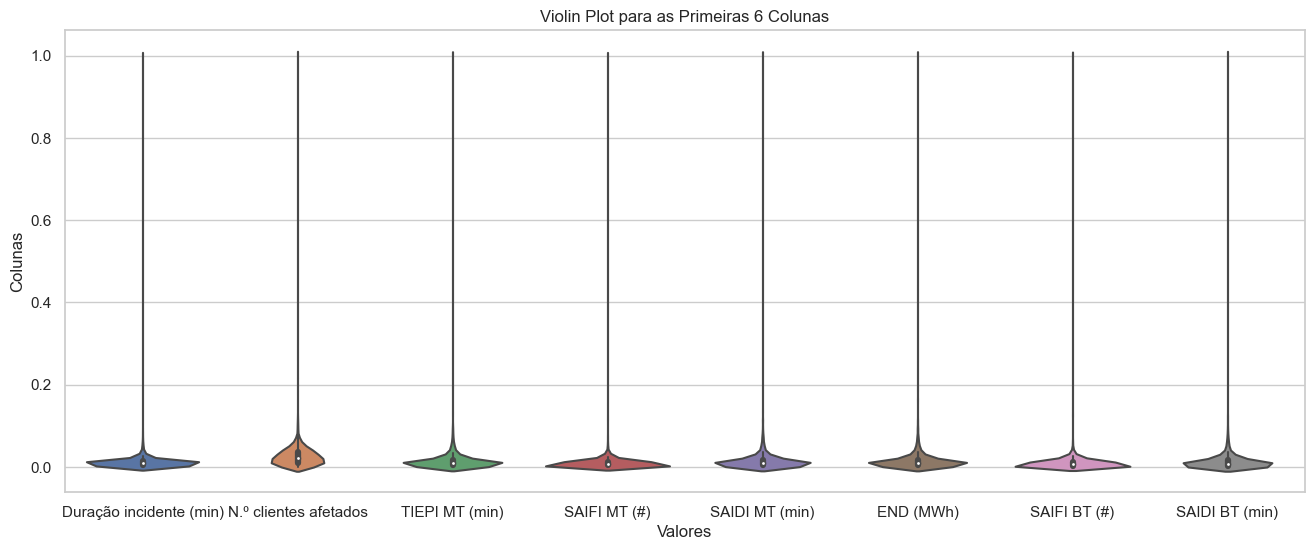

In [29]:
sns.set(style="whitegrid")

# Selecionar apenas as primeiras 6 colunas
subset_quebras_final = QuebrasFinal.iloc[:, 5:13]

# Plotar violin plot para as primeiras 6 colunas
plt.figure(figsize=(16, 6))
sns.violinplot(data=subset_quebras_final)
plt.title("Violin Plot para as Primeiras 6 Colunas")
plt.xlabel("Valores")
plt.ylabel("Colunas")
plt.show()

In [30]:
QuebrasFinal["Causa do incidente"].unique()

array(['Escavações', 'Abate De Árvores', 'Deslizamento De Terras', 'Aves',
       'Animais Não Aves', 'Malfeitoria/Vandalismo', 'Veículos',
       'Terramoto', 'Neve/Gelo/Granizo Condição Excecional',
       'Corpos Estranhos Na Rede', 'Vento Intensidade Excepcional',
       'Descarga Atmosférica Directa', 'Intervenções À Superficie',
       'Inundações Imprevisíveis', 'Risco Iminente Pessoas Ou Bens',
       'Incêndio', 'Furtos', 'Sabotagem',
       'Desabamento De Muros/Outras Cons',
       'Desabamento De Muros/Outras Construções',
       'Trabalhos De Terceiros ( Gruas,... )'], dtype=object)

## _Fogo_ --

In [31]:
CausaEstudo = 'Incêndio'

In [34]:
# Selecionar as variáveis de interesse
variaveis_soma = ['TIEPI MT (min)', 'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)']
variaveis_media = ['T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']

# Calcular a soma das variáveis de interesse
resultado_soma = QuebrasFinal[QuebrasFinal["Causa do incidente"] == CausaEstudo].groupby('Dia')[variaveis_soma].sum().reset_index()

# Calcular a média das variáveis adicionais
resultado_media = QuebrasFinal[QuebrasFinal["Causa do incidente"] == CausaEstudo].groupby('Dia')[variaveis_media].mean().reset_index()

# Juntar os resultados
Visualizar = resultado_soma.merge(resultado_media, on='Dia')
Visualizar

Dia  TIEPI MT (min)  SAIFI MT (#)  SAIDI MT (min)  END (MWh)  \
0     2        0.048471      0.022932        0.049929   0.049305   
1     3        0.444028      0.067742        0.618681   0.425224   
2     4        0.038075      0.031871        0.036712   0.037095   
3     5        0.027898      0.032939        0.045325   0.029718   
4     6        0.038570      0.045771        0.075172   0.037992   
5     7        0.040692      0.029271        0.052123   0.042564   
6     8        0.035798      0.055755        0.068213   0.034360   
7     9        0.002286      0.002871        0.005137   0.002222   
8    10        0.116264      0.095529        0.149887   0.111968   
9    11        0.010340      0.015110        0.022345   0.010783   
10   12        0.011638      0.021129        0.020775   0.011282   
11   13        0.181250      0.135329        0.349223   0.192591   
12   14        0.043821      0.020032        0.039133   0.042223   
13   15        0.101017      0.076245        0.169701   0.119426   
14   16        0.118269      0.064558        0.136625   0.122857   
15   17        0.073178      0.055871        0.102930   0.070429   
16   18        0.063878      0.050871        0.108931   0.061369   
17   19        0.096678      0.056319        0.127386   0.102815   
18   20        0.043725      0.043355        0.051077   0.042518   
19   21        0.002841      0.016613        0.004271   0.002816   
20   23        0.027799      0.010645        0.039418   0.026667   
21   24        0.029741      0.032226        0.075672   0.029060   
22   25        0.087229      0.076723        0.170259   0.098084   
23   26        0.016697      0.038810        0.009901   0.015916   
24   27        0.008821      0.028613        0.015544   0.008718   
25   28        0.005468      0.016839        0.007983   0.005470   
26   29        0.038198      0.002777        0.008477   0.037731   
27   31        0.061076      0.036313        0.074342   0.075194   

    SAIFI BT (#)  SAIDI BT (min)     T_MED     T_MAX     T_MIN    DD_MED  \
0       0.024857        0.051146  0.606232  0.610451  0.549708  0.027778   
1       0.052174        0.795153  0.866856  0.802850  0.847953  0.238889   
2       0.032696        0.030237  0.577856  0.602838  0.534711  0.708333   
3       0.033752        0.043592  0.742210  0.740301  0.691033  0.477778   
4       0.044261        0.073692  0.706327  0.789390  0.646199  0.651166   
5       0.020113        0.036360  0.715297  0.721496  0.679094  0.539318   
6       0.043913        0.060336  0.644193  0.696437  0.569591  0.707576   
7       0.001696        0.004421  0.532578  0.532067  0.517544  0.847222   
8       0.097183        0.126401  0.626062  0.659442  0.568713  0.797315   
9       0.012700        0.018845  0.580737  0.640143  0.540936  0.548611   
10      0.022217        0.022140  0.762040  0.874109  0.614035  0.911111   
11      0.129691        0.267358  0.710104  0.706519  0.691033  0.476852   
12      0.012087        0.021966  0.793201  0.800475  0.698830  0.683333   
13      0.075335        0.152954  0.639093  0.669359  0.614620  0.693333   
14      0.070774        0.146842  0.634672  0.653713  0.613799  0.699793   
15      0.059130        0.099095  0.682011  0.758314  0.598684  0.833333   
16      0.048174        0.094378  0.769122  0.800475  0.653509  0.886111   
17      0.042291        0.090169  0.627762  0.632779  0.623977  0.743763   
18      0.040522        0.047944  0.682720  0.741093  0.633528  0.592593   
19      0.013535        0.002942  0.651558  0.741093  0.608187  0.855556   
20      0.011304        0.044102  0.708215  0.795724  0.634503  0.802778   
21      0.020783        0.050290  0.612842  0.654790  0.594542  0.815741   
22      0.056317        0.110828  0.672197  0.749915  0.586048  0.867460   
23      0.072996        0.013953  0.461756  0.488519  0.461988  0.882407   
24      0.020565        0.012101  0.596317  0.622328  0.576023  0.647222   
25      0.017435        0.010618  0.743626  0.792162  0

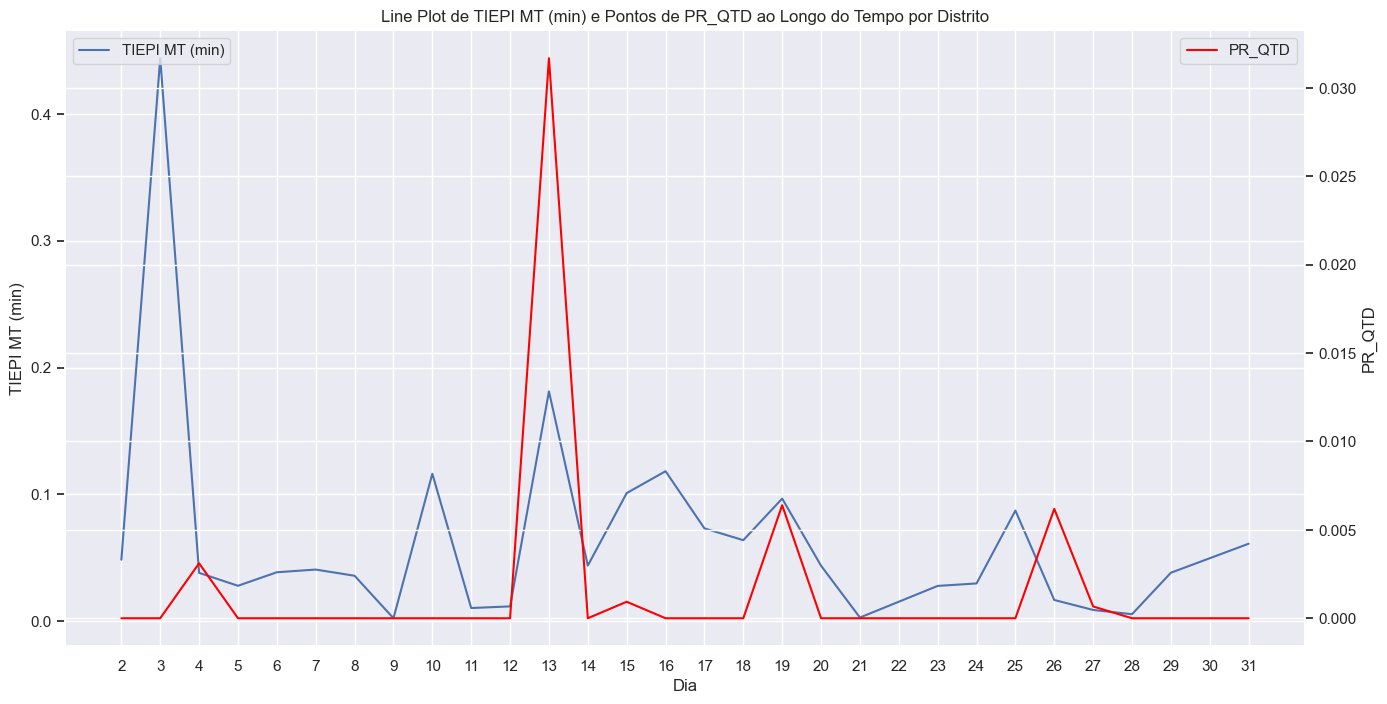

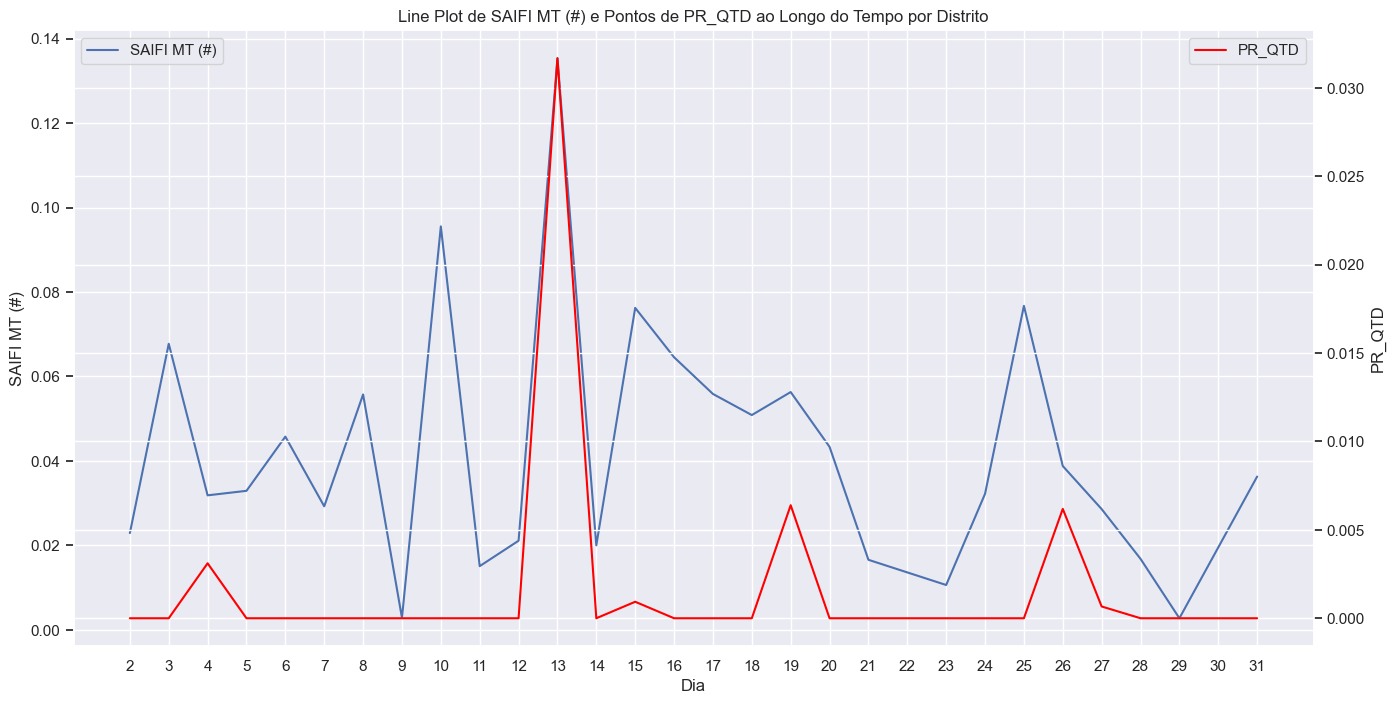

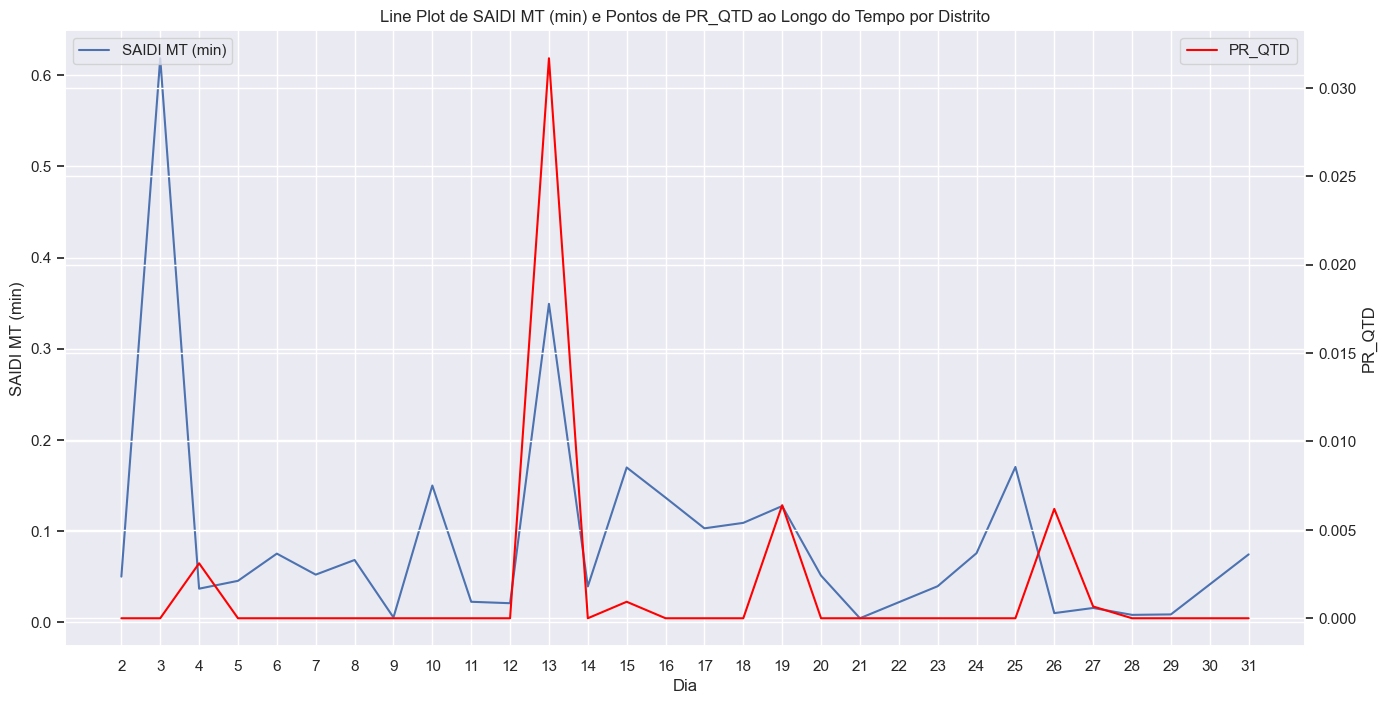

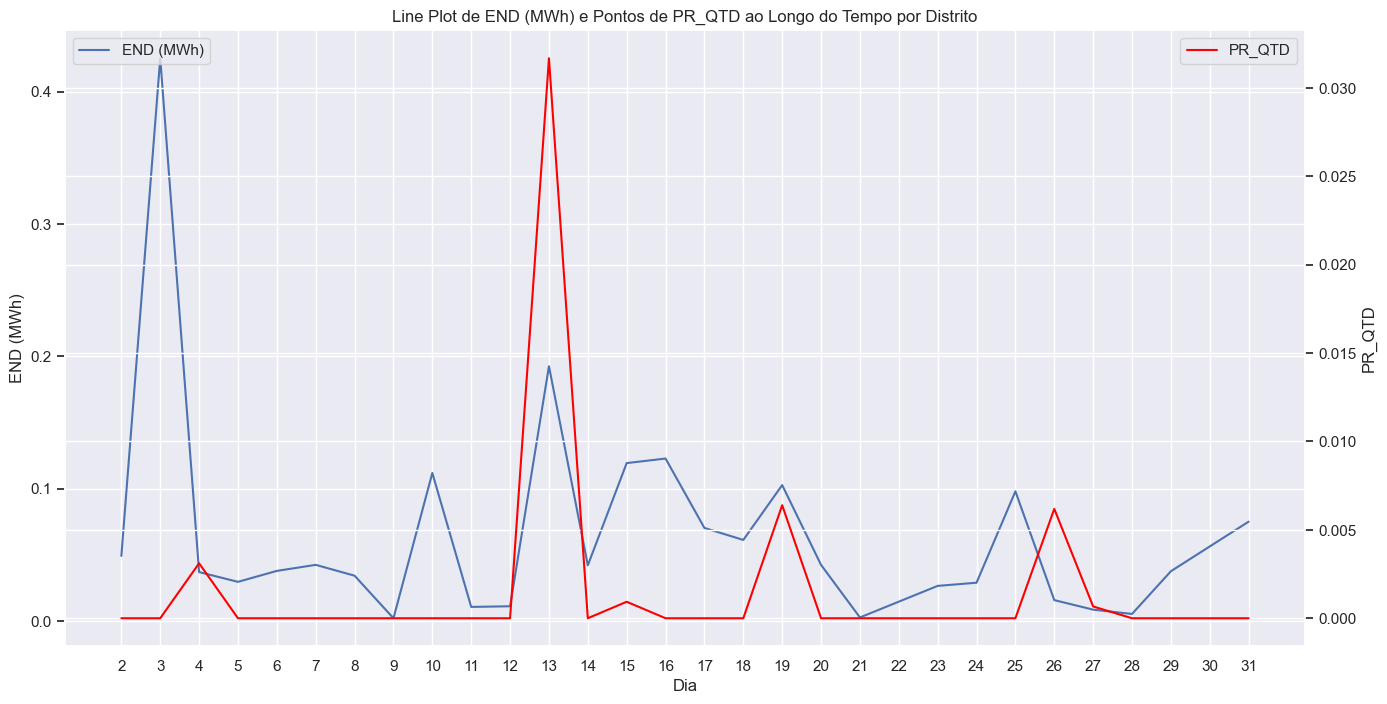

In [40]:
# Converter 'Dia' para numérico
Visualizar['Dia'] = Visualizar['Dia'].astype(int)

# Obter todos os dias do intervalo
todos_os_dias = range(Visualizar['Dia'].min(), Visualizar['Dia'].max() + 1)

if TT == "BT":
    variaveis = ['SAIFI BT (#)', 'SAIDI BT (min)']
else:
    variaveis = ["TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)", "END (MWh)"]

# Definir o estilo do Seaborn
sns.set_style("darkgrid")
tips = sns.load_dataset('tips')
sns.set_context('notebook', font_scale = 1)

IPMA = "PR_QTD"

# Loop sobre as variáveis
for i in variaveis:
    # Criar o line plot para 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)'
    plt.figure(figsize=(16, 8))
    ax1 = sns.lineplot(data=Visualizar, x='Dia', y=i, label=i, dashes=False, markers=True)

    # Adicionar legenda à esquerda
    plt.legend(loc='upper left')
    
    # Adicionar pontos para 'T_MED' em cada dia
    ax2 = ax1.twinx()
    sns.lineplot(data=Visualizar, x='Dia', y=IPMA, color='red', ax=ax2, label=IPMA)

    # Definir todos os dias no eixo x
    plt.xticks(todos_os_dias)
    
    # Adicionar título e etiquetas dos eixos
    plt.title(f'Line Plot de {i} e Pontos de {IPMA} ao Longo do Tempo por Distrito')
    ax1.set_xlabel('Dia')
    ax1.set_ylabel(i)
    ax2.set_ylabel(IPMA)
    
    # Mostrar o gráfico
    plt.show()


## _Descarga Atmosférica Directa_ --

In [41]:
CausaEstudo = 'Descarga Atmosférica Directa'

In [42]:
# Selecionar as variáveis de interesse
variaveis_soma = ['TIEPI MT (min)', 'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)']
variaveis_media = ['T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']

# Calcular a soma das variáveis de interesse
resultado_soma = QuebrasFinal[QuebrasFinal["Causa do incidente"] == CausaEstudo].groupby('Dia')[variaveis_soma].sum().reset_index()

# Calcular a média das variáveis adicionais
resultado_media = QuebrasFinal[QuebrasFinal["Causa do incidente"] == CausaEstudo].groupby('Dia')[variaveis_media].mean().reset_index()

# Juntar os resultados
Visualizar = resultado_soma.merge(resultado_media, on='Dia')
Visualizar

Dia  TIEPI MT (min)  SAIFI MT (#)  SAIDI MT (min)  END (MWh)  \
0     1        0.247598      0.165077        0.400170   0.251055   
1     2        0.082326      0.142577        0.122202   0.052066   
2     3        0.332887      0.143787        0.467032   0.339702   
3     4        0.071863      0.037545        0.105689   0.077579   
4     5        0.372731      0.224681        0.484998   0.381284   
5     6        0.106535      0.093484        0.145985   0.106631   
6     7        0.186359      0.115845        0.221768   0.177019   
7     8        0.386900      0.234600        0.423747   0.380606   
8     9        0.029313      0.058252        0.044502   0.029978   
9    10        0.062524      0.034632        0.083024   0.072546   
10   11        0.131324      0.098916        0.137742   0.126629   
11   12        0.238301      0.101010        0.254707   0.231613   
12   13        0.077624      0.072761        0.155406   0.087280   
13   14        0.195018      0.161103        0.336500   0.220981   
14   15        0.220431      0.177132        0.268138   0.237345   
15   16        0.201342      0.159526        0.263605   0.195959   
16   17        0.132622      0.120261        0.212516   0.128778   
17   18        0.070620      0.058277        0.114153   0.067526   
18   19        0.170909      0.097419        0.319635   0.163645   
19   20        0.087090      0.042535        0.081013   0.092935   
20   21        1.011665      0.211716        0.803401   1.035670   
21   22        0.037702      0.043748        0.051233   0.037432   
22   23        0.310982      0.174958        0.361892   0.299735   
23   24        0.038204      0.028565        0.045045   0.039387   
24   25        0.015912      0.016484        0.032805   0.014530   
25   26        0.119795      0.068626        0.189366   0.115249   
26   27        0.581208      0.139874        0.515789   0.559003   
27   28        0.424463      0.310229        0.593124   0.407695   
28   29        0.049733      0.057971        0.070079   0.050078   
29   30        0.123898      0.098758        0.158350   0.123443   
30   31        0.204196      0.117071        0.206863   0.202400   

    SAIFI BT (#)  SAIDI BT (min)     T_MED     T_MAX     T_MIN    DD_MED  \
0       0.172287        0.400839  0.499455  0.527133  0.536437  0.742822   
1       0.484748        0.108734  0.412181  0.436659  0.438109  0.323012   
2       0.135809        0.530908  0.569169  0.572842  0.598441  0.318115   
3       0.032778        0.102703  0.456091  0.481710  0.428655  0.632778   
4       0.215317        0.435030  0.503895  0.510986  0.527595  0.579340   
5       0.086383        0.135700  0.488904  0.530457  0.481097  0.693333   
6       0.112791        0.209431  0.558428  0.567399  0.545322  0.577431   
7       0.275670        0.490076  0.575656  0.597079  0.585234  0.733508   
8       0.054596        0.043819  0.382436  0.375297  0.395712  0.552778   
9       0.036491        0.070925  0.648725  0.685669  0.657895  0.300926   
10      0.092748        0.144984  0.551388  0.545808  0.551510  0.519903   
11      0.067487        0.182882  0.520609  0.519151  0.540865  0.499306   
12      0.060183        0.111779  0.562930  0.553105  0.598997  0.439683   
13      0.153352        0.345924  0.608215  0.629454  0.589181  0.359167   
14      0.180639        0.315390  0.554027  0.577706  0.543233  0.403373   
15      0.149357        0.253630  0.505537  0.516735  0.520468  0.501515   
16      0.117665        0.190711  0.511718  0.518031  0.536151  0.497980   
17      0.028957        0.054957  0.461190  0.529691  0.447953  0.623986   
18      0.110957        0.347595  0.668151  0.640991  0.690476  0.684675   
19      0.030322        0.050640  0.570979  0.581684  0.587719  0.629321   
20      0.229030        0.842307  0.599282  0.621649  0.609162  0.551239   
21      0.022861        0.036006  0.540132  0.582740  0.500000  0.626852   
22      0.145239        0.332342  0.553982  0.531803  0.591293  0.495395   
23 

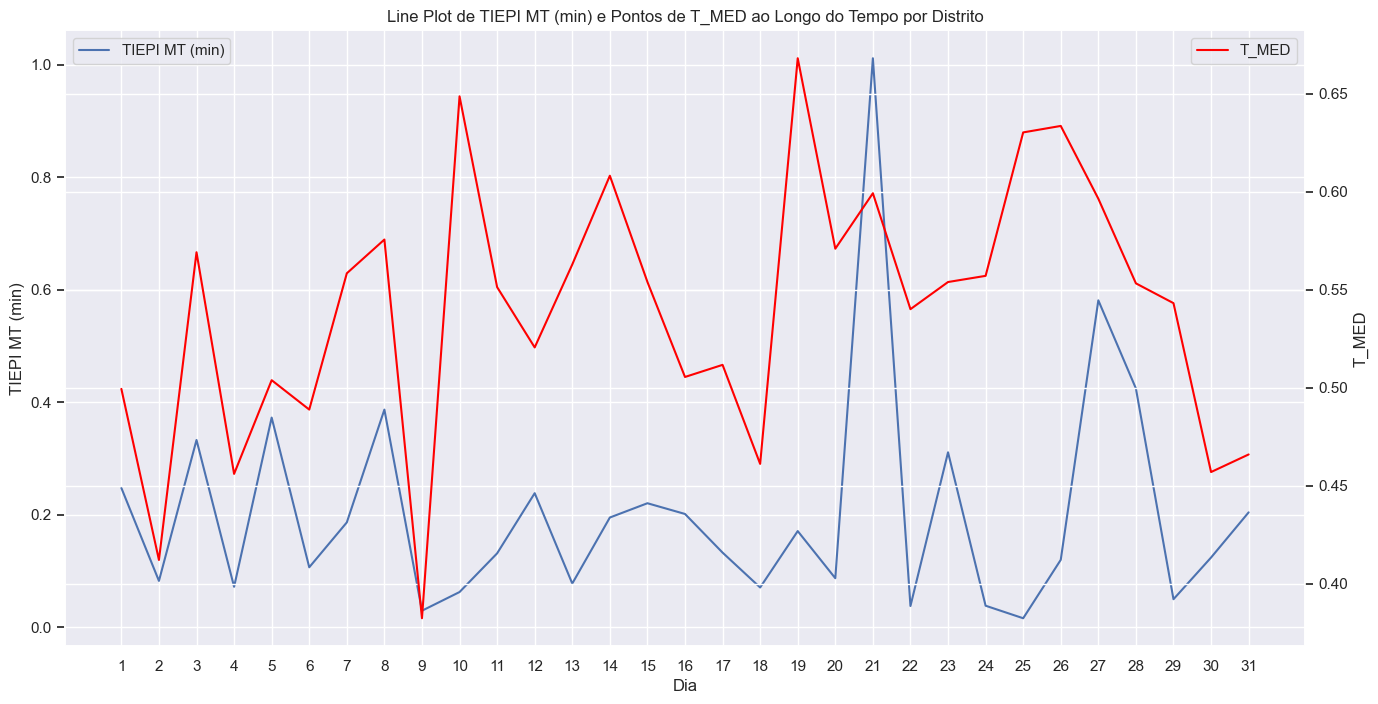

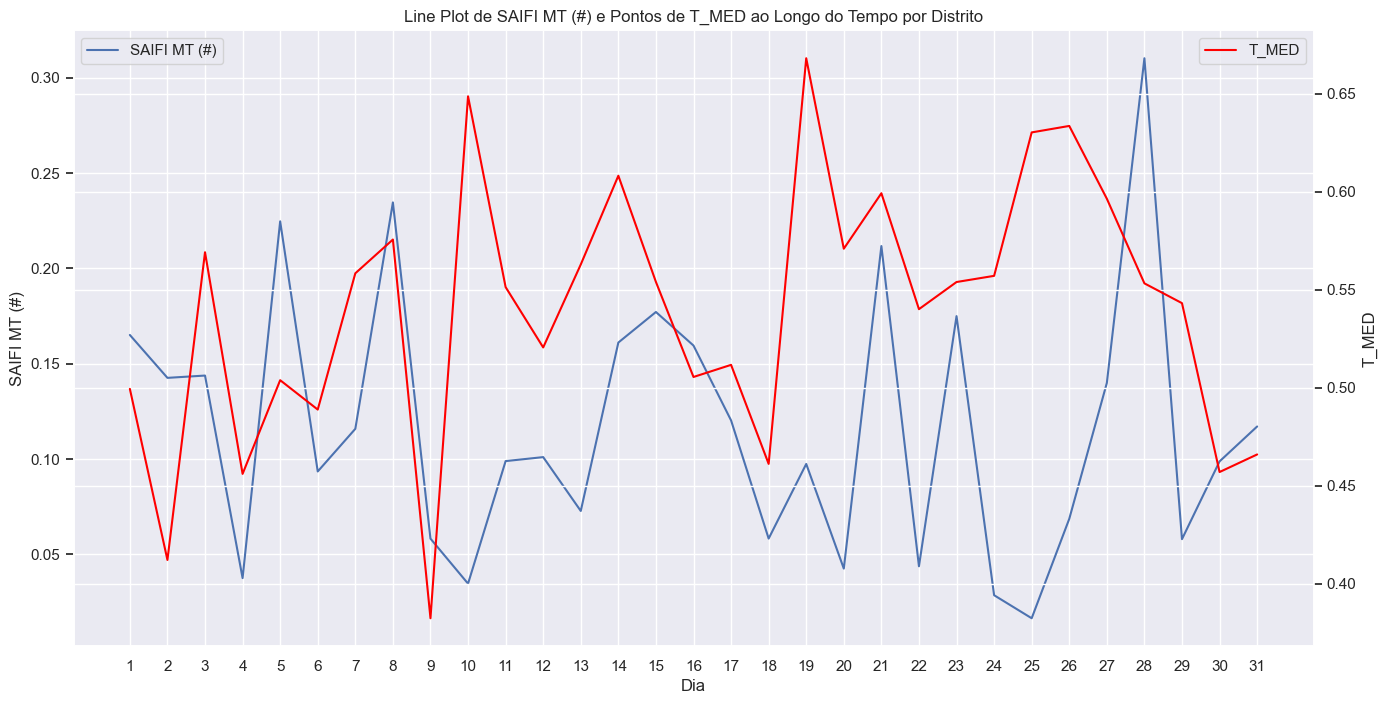

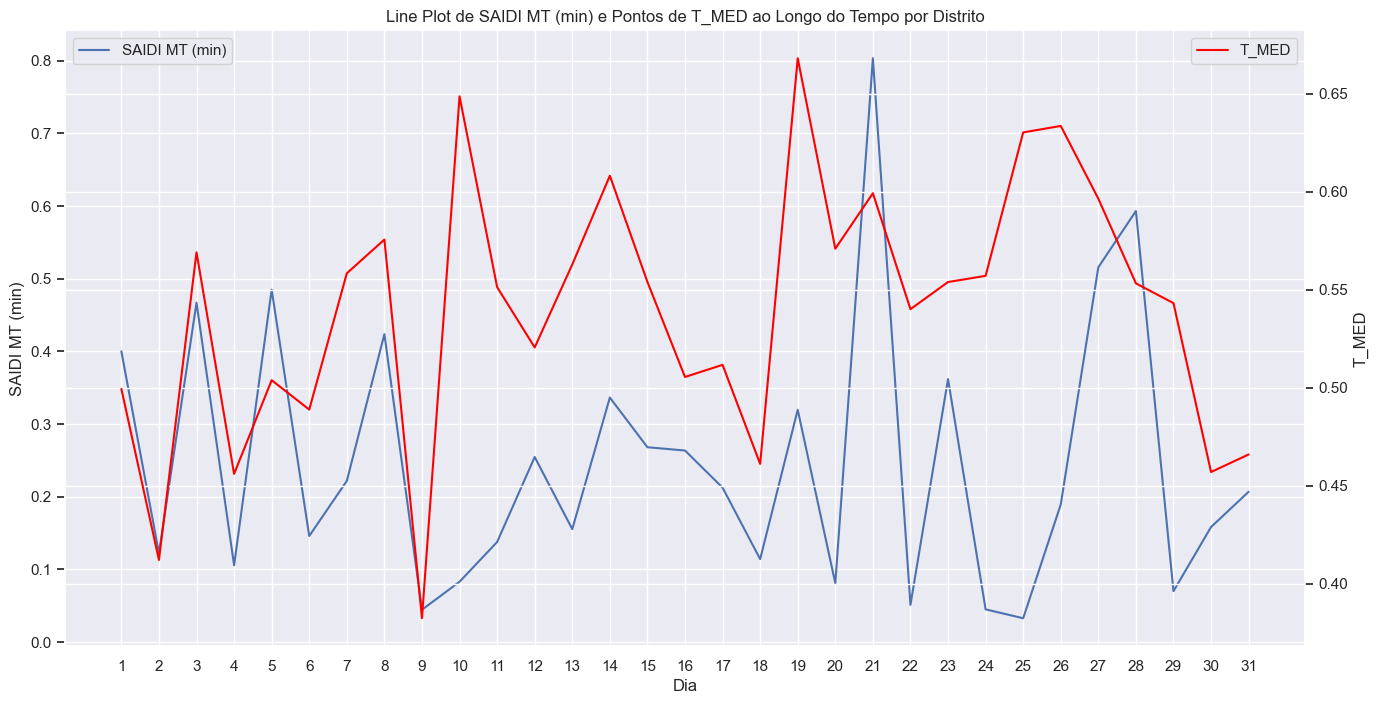

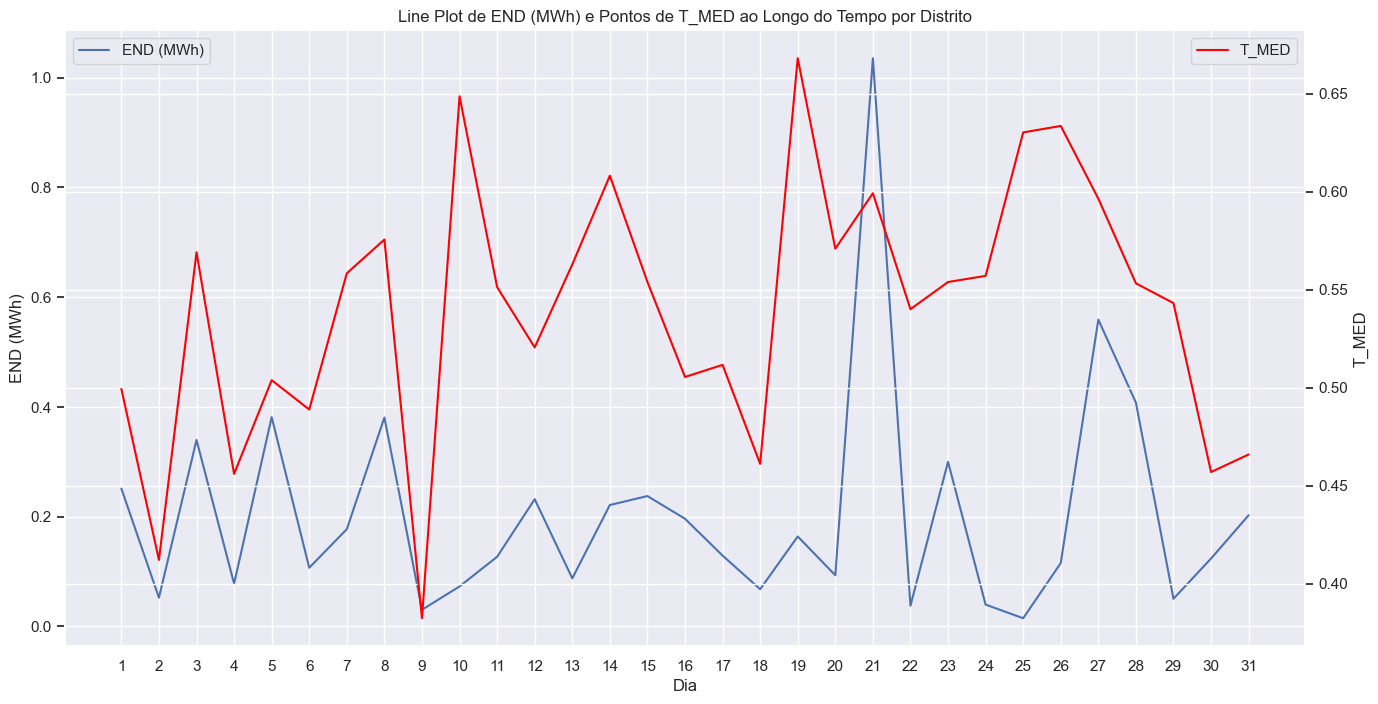

In [43]:
# Converter 'Dia' para numérico
Visualizar['Dia'] = Visualizar['Dia'].astype(int)

# Obter todos os dias do intervalo
todos_os_dias = range(Visualizar['Dia'].min(), Visualizar['Dia'].max() + 1)

if TT == "BT":
    variaveis = ['SAIFI BT (#)', 'SAIDI BT (min)']
else:
    variaveis = ["TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)", "END (MWh)"]

# Definir o estilo do Seaborn
sns.set_style("darkgrid")
tips = sns.load_dataset('tips')
sns.set_context('notebook', font_scale = 1)

IPMA = "T_MED"

# Loop sobre as variáveis
for i in variaveis:
    # Criar o line plot para 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)'
    plt.figure(figsize=(16, 8))
    ax1 = sns.lineplot(data=Visualizar, x='Dia', y=i, label=i, dashes=False, markers=True)

    # Adicionar legenda à esquerda
    plt.legend(loc='upper left')
    
    # Adicionar pontos para 'T_MED' em cada dia
    ax2 = ax1.twinx()
    sns.lineplot(data=Visualizar, x='Dia', y=IPMA, color='red', ax=ax2, label=IPMA)

    # Definir todos os dias no eixo x
    plt.xticks(todos_os_dias)
    
    # Adicionar título e etiquetas dos eixos
    plt.title(f'Line Plot de {i} e Pontos de {IPMA} ao Longo do Tempo por Distrito')
    ax1.set_xlabel('Dia')
    ax1.set_ylabel(i)
    ax2.set_ylabel(IPMA)
    
    # Mostrar o gráfico
    plt.show()


In [20]:
# # Converter 'Dia' para numérico
# Visualizar['Dia'] = Visualizar['Dia'].astype(int)

# # Obter todos os dias do intervalo
# todos_os_dias = range(1, 31)

# # Criar um DataFrame com todos os dias do intervalo
# todos_os_dias_df = pd.DataFrame({'Dia': todos_os_dias})

# # Mesclar o DataFrame com todos os dias com o DataFrame original para preencher os dias sem valores com zero
# Visualizar = pd.merge(todos_os_dias_df, Visualizar, on='Dia', how='left').fillna(0)

# if TT == "BT":
#     variaveis = ['SAIFI BT (#)', 'SAIDI BT (min)']
# else:
#     variaveis = ["TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)", "END (MWh)"]

# # Definir o estilo do Seaborn
# sns.set_style("darkgrid")
# tips = sns.load_dataset('tips')
# sns.set_context('notebook', font_scale = 1)

# IPMA = "T_MED"

# # Loop sobre as variáveis
# for i in variaveis:
#     # Criar o line plot para 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)'
#     plt.figure(figsize=(16, 8))
#     ax1 = sns.lineplot(data=Visualizar, x='Dia', y=i, label=i, dashes=False, markers=True, marker='o')

#     # Adicionar legenda à esquerda
#     plt.legend(loc='upper left')
    
#     # Adicionar pontos para 'T_MED' em cada dia
#     ax2 = ax1.twinx()
#     sns.barplot(data=Visualizar, x='Dia', y=IPMA, ax=ax2, alpha=0.3)

#     # Definir todos os dias no eixo x
#     plt.xticks(todos_os_dias)
    
#     # Adicionar título e etiquetas dos eixos
#     plt.title(f'Line Plot de {i} e Pontos de {IPMA} ao Longo do Tempo por Distrito')
#     ax1.set_xlabel('Dia')
#     ax1.set_ylabel(i)
#     ax2.set_ylabel(IPMA)
    
#     # Mostrar o gráfico
#     plt.show()

## _Vento Intensidade Excepcional_ --

In [44]:
CausaEstudo = 'Vento Intensidade Excepcional'

In [45]:
# Selecionar as variáveis de interesse
variaveis_soma = ['TIEPI MT (min)', 'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)']
variaveis_media = ['T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']

# Calcular a soma das variáveis de interesse
resultado_soma = QuebrasFinal[QuebrasFinal["Causa do incidente"] == CausaEstudo].groupby('Dia')[variaveis_soma].sum().reset_index()

# Calcular a média das variáveis adicionais
resultado_media = QuebrasFinal[QuebrasFinal["Causa do incidente"] == CausaEstudo].groupby('Dia')[variaveis_media].mean().reset_index()

# Juntar os resultados
Visualizar = resultado_soma.merge(resultado_media, on='Dia')
Visualizar

Dia  TIEPI MT (min)  SAIFI MT (#)  SAIDI MT (min)  END (MWh)  SAIFI BT (#)  \
0    2        0.014405      0.017661        0.018213   0.013681      0.019617   
1    9        0.001121      0.000742        0.004383   0.001197      0.000000   
2   10        0.115917      0.022581        0.054932   0.107010      0.003870   
3   13        0.016484      0.012084        0.018778   0.016031      0.011022   
4   14        1.004171      1.000355        1.000812   1.004056      1.000000   
5   18        0.326219      0.141413        0.278726   0.330471      0.122713   
6   19        0.151940      0.090845        0.183578   0.161643      0.030513   
7   20        0.021321      0.011971        0.038376   0.022638      0.010778   
8   22        0.013735      0.009355        0.015275   0.013334      0.007826   
9   25        0.475038      0.121413        0.366636   0.480104      0.106004   

   SAIDI BT (min)     T_MED     T_MAX     T_MIN    DD_MED    DD_FFX    FF_MED  \
0        0.016930  0.407932  0.346793  0.438596  0.780556  0.911111  0.408696   
1        0.000087  0.158640  0.204276  0.204678  0.566667  0.875000  0.591304   
2        0.008925  0.481586  0.420428  0.540936  0.589847  0.638444  0.327145   
3        0.024532  0.580737  0.644893  0.507310  0.550000  0.837500  0.286957   
4        1.000000  0.381020  0.350356  0.400585  0.698611  0.756944  0.154437   
5        0.298885  0.521246  0.468612  0.563910  0.389683  0.542857  0.366460   
6        0.064396  0.447238  0.357779  0.524854  0.599547  0.606840  0.663487   
7        0.040300  0.453258  0.356295  0.567251  0.700000  0.672222  0.921739   
8        0.015835  0.549575  0.524941  0.573099  0.618938  0.661329  0.272061   
9        0.332163  0.280968  0.234507  0.338650  0.618434  0.841919  0.327273   

     FF_MAX    PR_QTD  
0  0.469965  0.008661  
1  0.795053  0.300466  
2  0.467080  0.169887  
3  0.540636  0.072113  
4  0.701053  0.136243  
5  0.725896  0.156372  
6  0.679989  0.187375  
7  0.720848  0.098601  
8  0.375861  0.083944  
9  0.702859  0.081582

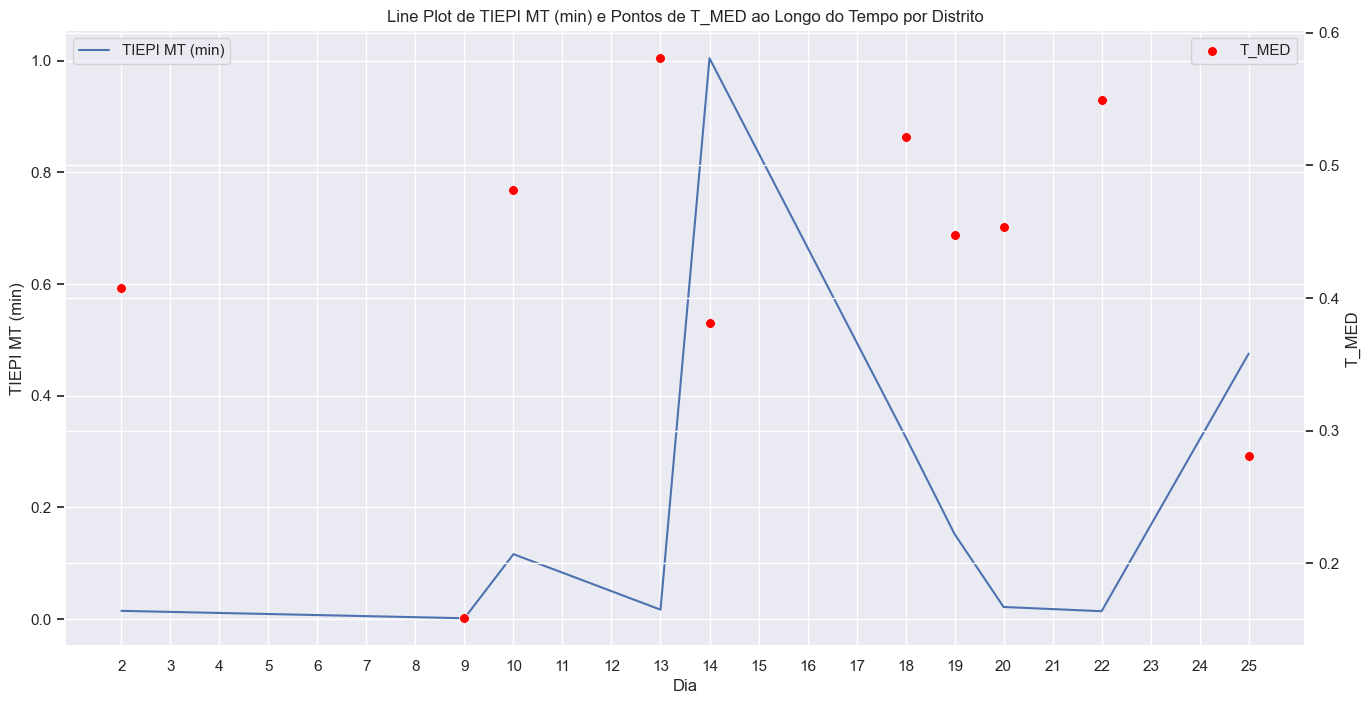

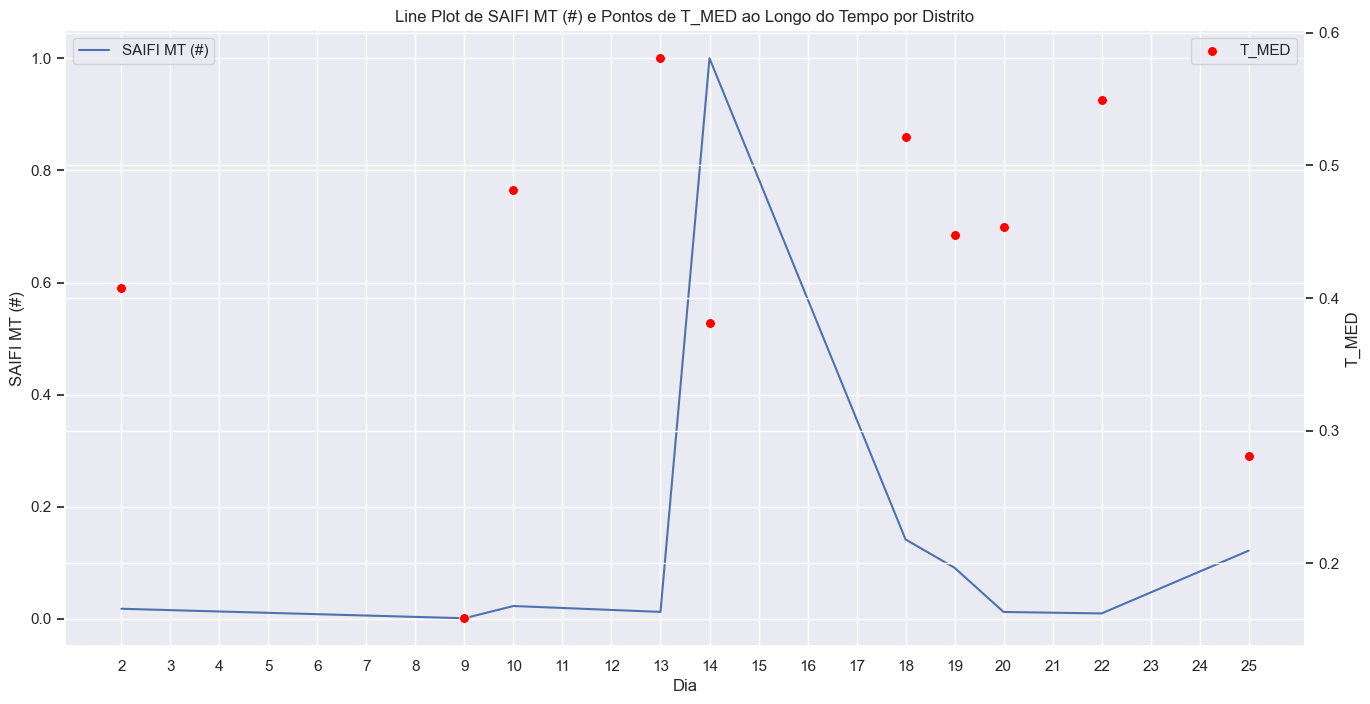

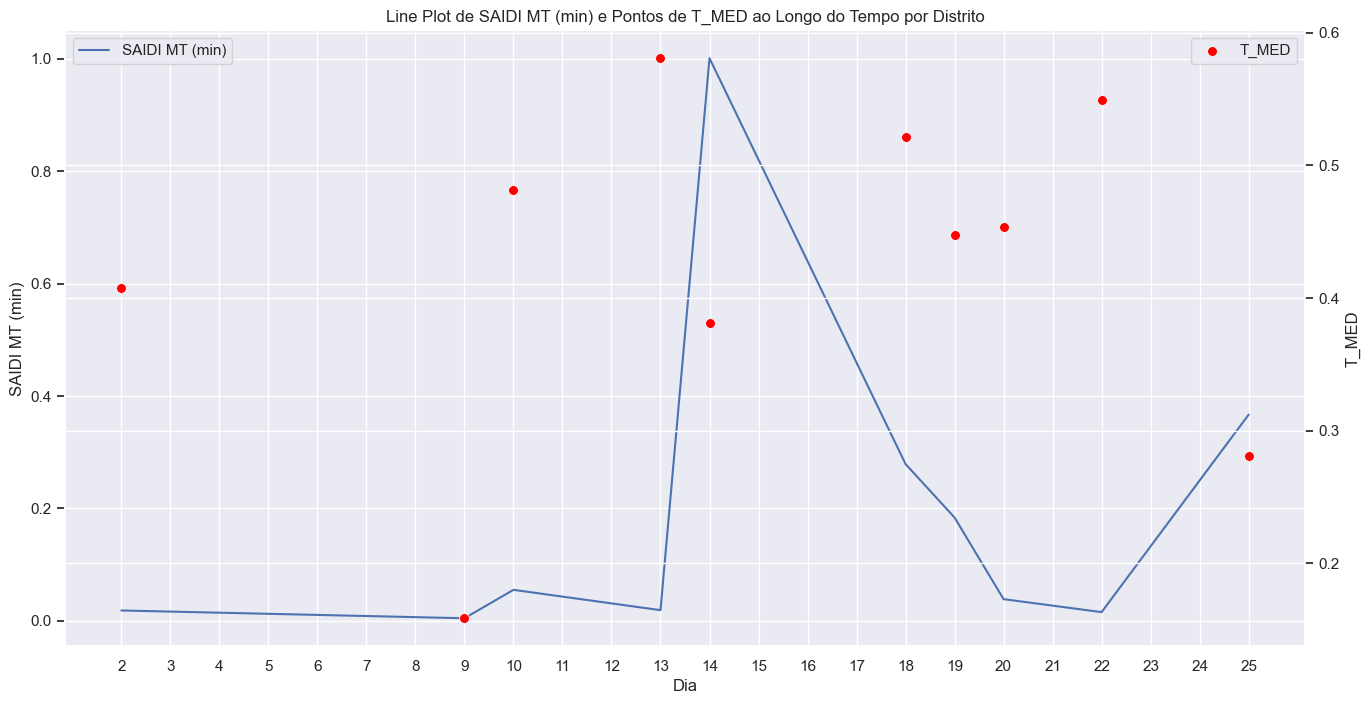

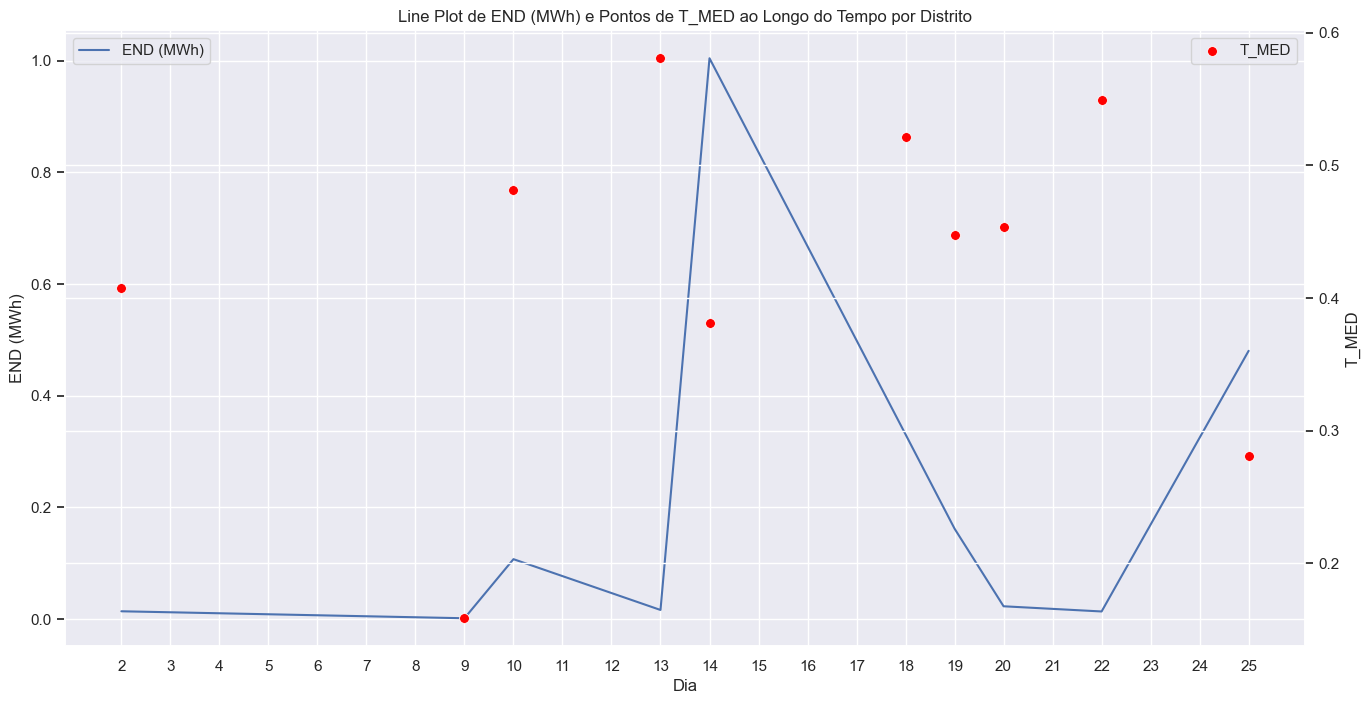

In [46]:
# Converter 'Dia' para numérico
Visualizar['Dia'] = Visualizar['Dia'].astype(int)

# Obter todos os dias do intervalo
todos_os_dias = range(Visualizar['Dia'].min(), Visualizar['Dia'].max() + 1)

if TT == "BT":
    variaveis = ['SAIFI BT (#)', 'SAIDI BT (min)']
else:
    variaveis = ["TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)", "END (MWh)"]

# Definir o estilo do Seaborn
sns.set_style("darkgrid")
tips = sns.load_dataset('tips')
sns.set_context('notebook', font_scale = 1)

IPMA = "T_MED"

# Loop sobre as variáveis
for i in variaveis:
    # Criar o line plot para 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)'
    plt.figure(figsize=(16, 8))
    ax1 = sns.lineplot(data=Visualizar, x='Dia', y=i, label=i, dashes=False, markers=True)

    # Adicionar legenda à esquerda
    plt.legend(loc='upper left')
    
    # Adicionar pontos para 'T_MED' em cada dia
    ax2 = ax1.twinx()
    sns.scatterplot(data=Visualizar, x='Dia', y=IPMA, color='red', s=50, ax=ax2, label=IPMA)

    # Definir todos os dias no eixo x
    plt.xticks(todos_os_dias)
    
    # Adicionar título e etiquetas dos eixos
    plt.title(f'Line Plot de {i} e Pontos de {IPMA} ao Longo do Tempo por Distrito')
    ax1.set_xlabel('Dia')
    ax1.set_ylabel(i)
    ax2.set_ylabel(IPMA)
    
    # Mostrar o gráfico
    plt.show()


## _Aves_ --

In [24]:
QuebrasFinal

Código do Relatório       Concelho Data do incidente Nível de Tensão  \
0      EDPD_2018_JAN_T_1         Almada        2018-01-02              MT   
1      EDPD_2018_JAN_T_2          Sertã        2018-01-02              MT   
2      EDPD_2018_JAN_T_3     Felgueiras        2018-01-04              MT   
4      EDPD_2018_JAN_T_5           Nisa        2018-01-09              MT   
6      EDPD_2018_JAN_T_7  Idanha-A-Nova        2018-01-11              MT   
...                  ...            ...               ...             ...   
7285  EDPD_2017_NOV_T_43          Lagos        2017-11-10              MT   
7286  EDPD_2017_NOV_T_44          Lagos        2017-11-28              MT   
7287  EDPD_2017_NOV_T_45       Portimão        2017-11-07              MT   
7288  EDPD_2017_NOV_T_46         Ansião        2017-11-08              MT   
7289  EDPD_2017_NOV_T_47         Tavira        2017-11-06              MT   

                Causa do incidente  Duração incidente (min)  \
0                       Escavações                 0.003524   
1                 Abate De Árvores                 0.010842   
2           Deslizamento De Terras                 0.040184   
4                             Aves                 0.007861   
6                 Abate De Árvores                 0.008742   
...                            ...                      ...   
7285                      Veículos                 0.015044   
7286  Descarga Atmosférica Directa                 0.018432   
7287     Intervenções À Superficie                 0.006776   
7288              Abate De Árvores                 0.017958   
7289                          Aves                 0.007590   

      N.º clientes afetados  TIEPI MT (min)  SAIFI MT (#)  SAIDI MT (min)  \
0                  0.010026        0.003436      0.001429        0.001588   
1                  0.006643        0.003435      0.005710        0.010666   
2                  0.041922        0.022515      0.008565        0.023209   
4                  0.020973        0.005178      0.004997        0.006488   
6                  0.034733        0.008804      0.012490        0.015872   
...                     ...             ...           ...             ...   
7285               0.042213        0.026351      0.019968        0.018092   
7286               0.028307        0.031395      0.032484        0.046396   
7287               0.008426        0.006417      0.002484        0.004797   
7288               0.045813        0.005888      0.018194        0.013012   
7289               0.019579        0.004879      0.032484        0.018421   

      ...  Indice de Envelhecimento     Rural     T_MED     T_MAX     T_MIN  \
0     ...                  0.101575  0.000000  0.308782  0.361045  0.207602   
1     ...                  0.242952  1.000000  0.305949  0.275534  0.312865   
2     ...                  0.046296  0.800000  0.402266  0.299287  0.508772   
4     ...                  0.529989  1.000000  0.144476  0.133017  0.195906   
6     ...                  0.561360  1.000000  0.235127  0.239905  0.266082   
...   ...                       ...       ...       ...       ...       ...   
7285  ...                  0.088585  0.105263  0.464589  0.470309  0.456140   
7286  ...                  0.088585  0.105263  0.521246  0.446556  0.596491   
7287  ...                  0.060531  0.666667  0.478754  0.444181  0.459064   
7288  ...                  0.260365  1.000000  0.300283  0.351544  0.225146   
7289  ...                  0.168878  0.833333  0.509915  0.482185  0.529240   

        DD_MED    DD_FFX    FF_MED    FF_MAX    PR_QTD  
0     0.539824  0.627128  0.247303  0.326089  0.000000  
1     0.691667  0.750000  0.243478  0.265018  0.000000  
2     0.547222  0.500000  0.339130  0.487633  0.026649  
4     0.380556  0.327778  0.356522  0.522968  0.105929  
6     0.783333  0.891667  0.330435  0.462898  0.001332  
...        ...       ...       ...       ...       ...  
7285  0.116667  0.219444  0.321739  0.314488  0.00

In [47]:
CausaEstudo = 'Aves'

In [48]:
# Selecionar as variáveis de interesse
variaveis_soma = ['TIEPI MT (min)', 'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)']
variaveis_media = ['T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']

# Calcular a soma das variáveis de interesse
resultado_soma = QuebrasFinal[QuebrasFinal["Causa do incidente"] == CausaEstudo].groupby('Dia')[variaveis_soma].sum().reset_index()

# Calcular a média das variáveis adicionais
resultado_media = QuebrasFinal[QuebrasFinal["Causa do incidente"] == CausaEstudo].groupby('Dia')[variaveis_media].mean().reset_index()

# Juntar os resultados
Visualizar = resultado_soma.merge(resultado_media, on='Dia')
Visualizar

Dia  TIEPI MT (min)  SAIFI MT (#)  SAIDI MT (min)  END (MWh)  \
0     1        0.359384      0.262503        0.343022   0.379715   
1     2        0.415493      0.434181        0.517613   0.419352   
2     3        0.681143      0.444216        0.605111   0.683090   
3     4        0.261958      0.264890        0.284095   0.266883   
4     5        0.455165      0.434697        0.521508   0.475542   
5     6        0.276858      0.251335        0.283246   0.280114   
6     7        0.353625      0.492977        0.432674   0.364010   
7     8        0.487020      0.277303        0.420811   0.522130   
8     9        0.432676      0.482635        0.481015   0.436368   
9    10        0.396397      0.377845        0.505808   0.410057   
10   11        0.350160      0.319652        0.399212   0.363914   
11   12        0.290134      0.228358        0.327062   0.307781   
12   13        0.398418      0.336419        0.434092   0.420421   
13   14        0.296461      0.248048        0.372303   0.315368   
14   15        0.369313      0.317232        0.386139   0.391518   
15   16        0.528844      0.330565        0.590171   0.548603   
16   17        0.575774      0.385903        0.540752   0.591563   
17   18        0.589373      0.409213        0.491525   0.641955   
18   19        0.495787      0.373713        0.500411   0.513923   
19   20        0.502759      0.385861        0.568112   0.518458   
20   21        0.364736      0.343600        0.415305   0.368884   
21   22        0.414061      0.292781        0.512752   0.444943   
22   23        0.533066      0.332990        0.499977   0.543024   
23   24        0.264090      0.175848        0.237724   0.272016   
24   25        0.540221      0.320032        0.581902   0.562822   
25   26        0.561068      0.377268        0.482818   0.589808   
26   27        0.370937      0.294203        0.388454   0.383183   
27   28        0.337313      0.242981        0.407403   0.336448   
28   29        0.229321      0.284139        0.294176   0.242025   
29   30        0.598353      0.507306        0.641192   0.610484   
30   31        0.472848      0.291158        0.460279   0.508393   

    SAIFI BT (#)  SAIDI BT (min)     T_MED     T_MAX     T_MIN    DD_MED  \
0       0.490852        0.312237  0.419610  0.418824  0.417289  0.584050   
1       0.369183        0.384001  0.435370  0.453342  0.424311  0.627129   
2       0.323661        0.451230  0.431360  0.447511  0.417660  0.611481   
3       0.163204        0.146202  0.393189  0.401165  0.400589  0.563788   
4       0.245765        0.304645  0.407902  0.411765  0.431224  0.604558   
5       0.159300        0.175665  0.401143  0.407715  0.409591  0.589429   
6       0.421491        0.312883  0.451721  0.444786  0.464857  0.663846   
7       0.194643        0.277281  0.437740  0.455744  0.437755  0.636995   
8       0.336035        0.290731  0.432552  0.429846  0.451126  0.593776   
9       0.249074        0.273670  0.429206  0.439493  0.425263  0.616915   
10      0.245861        0.244361  0.427336  0.421718  0.443917  0.679852   
11      0.179370        0.207335  0.387900  0.384035  0.401420  0.686549   
12      0.228622        0.252440  0.450659  0.458513  0.440669  0.602116   
13      0.164039        0.237163  0.401327  0.409406  0.413012  0.534528   
14      0.266287        0.303656  0.432272  0.436731  0.438064  0.582175   
15      0.249122        0.437110  0.483940  0.483774  0.488370  0.691809   
16      0.314978        0.408614  0.459110  0.465137  0.460742  0.548319   
17      0.357496        0.420224  0.433294  0.440440  0.447301  0.566076   
18      0.289109        0.330140  0.424633  0.433658  0.431687  0.632843   
19      0.249230        0.328413  0.400547  0.385143  0.424698  0.580788   
20      0.261926        0.249116  0.426029  0.433497  0.428671  0.608383   
21      0.155487        0.224779  0.363709  0.370716  0.382192  0.639508   
22      0.232313        0.354025  0.399696  0.422577  0.390039  0.726519   
23 

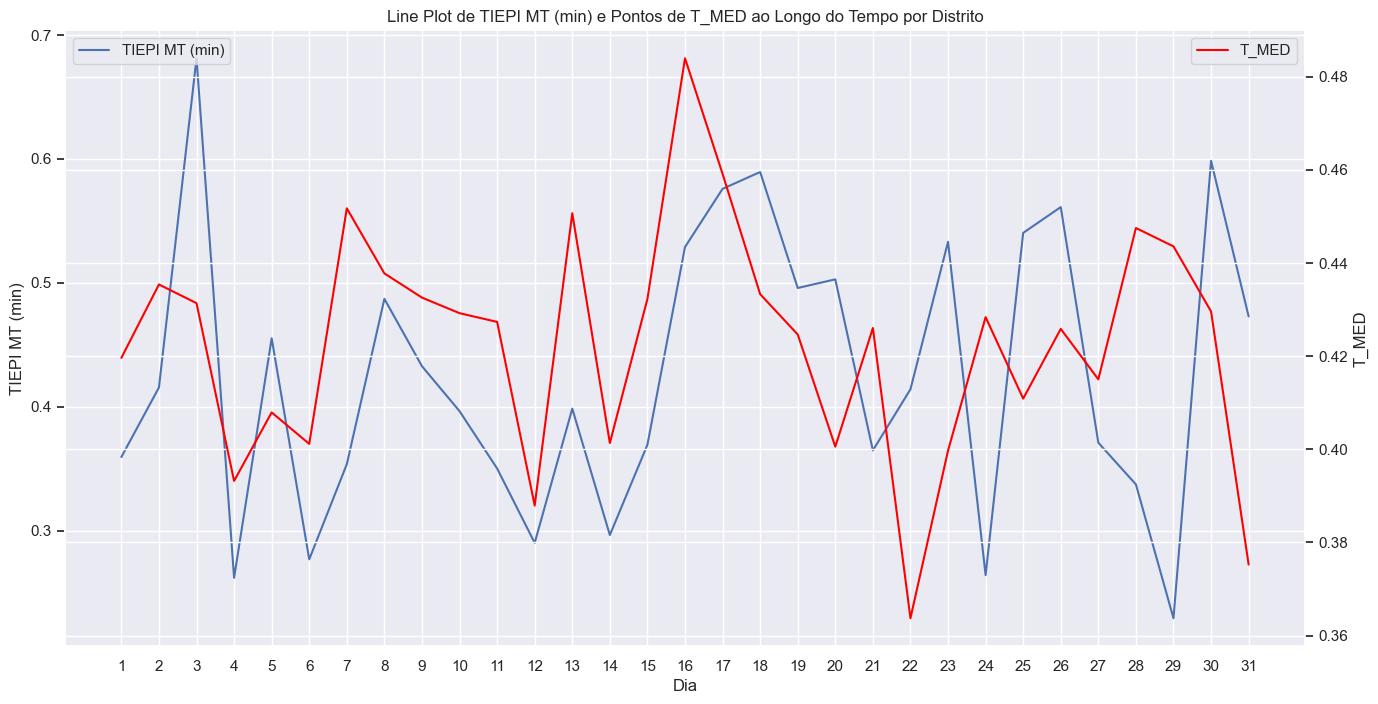

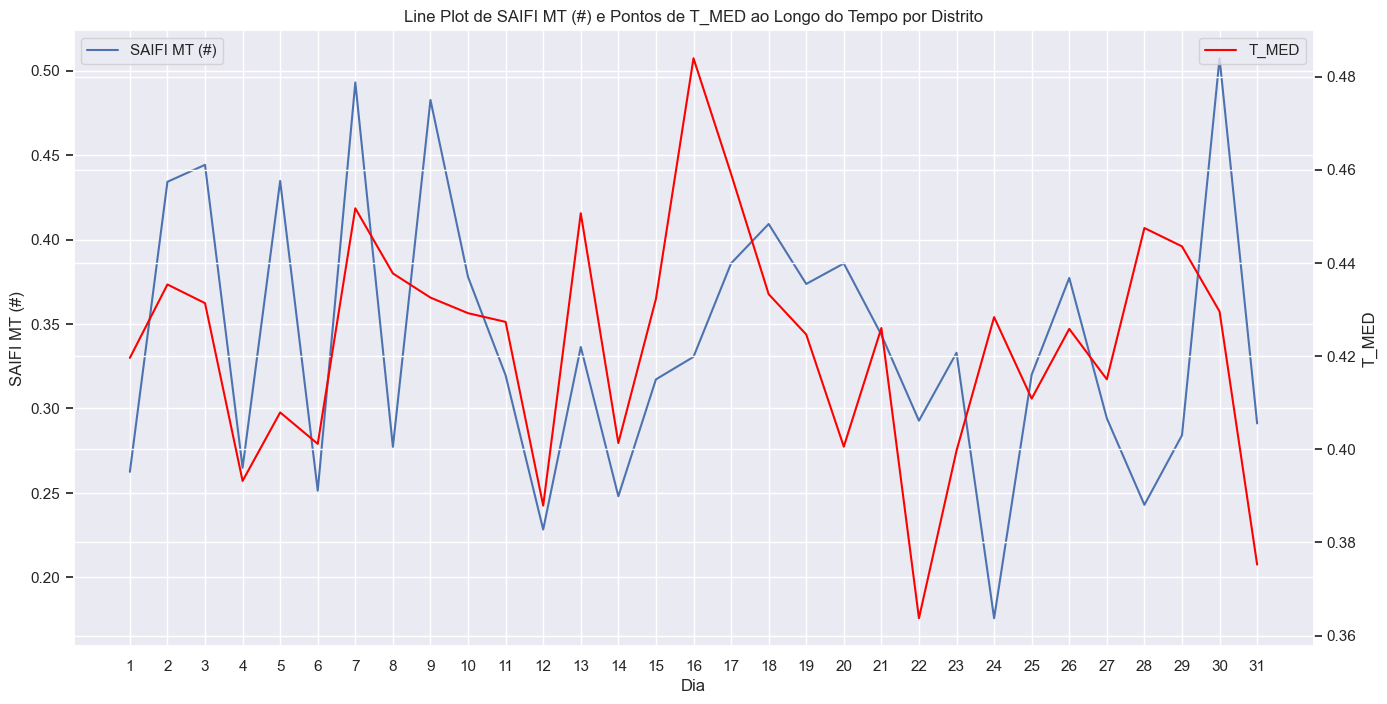

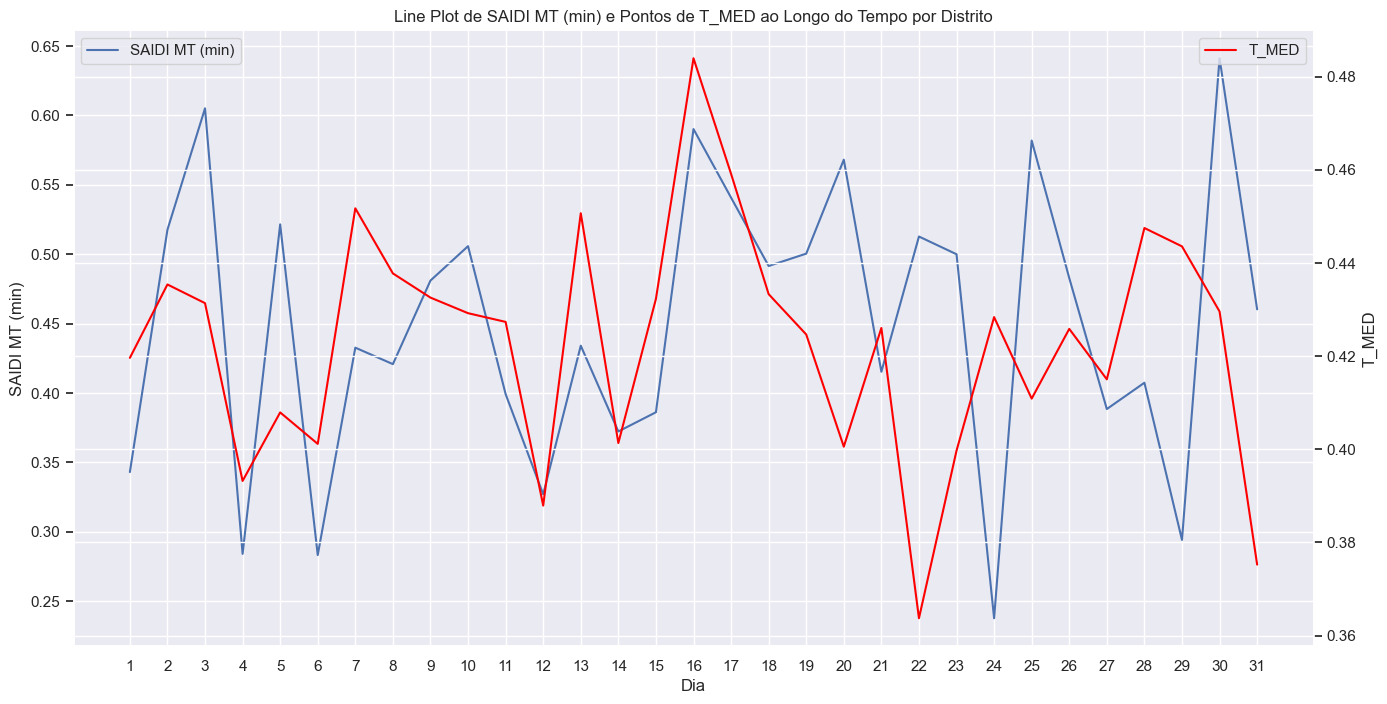

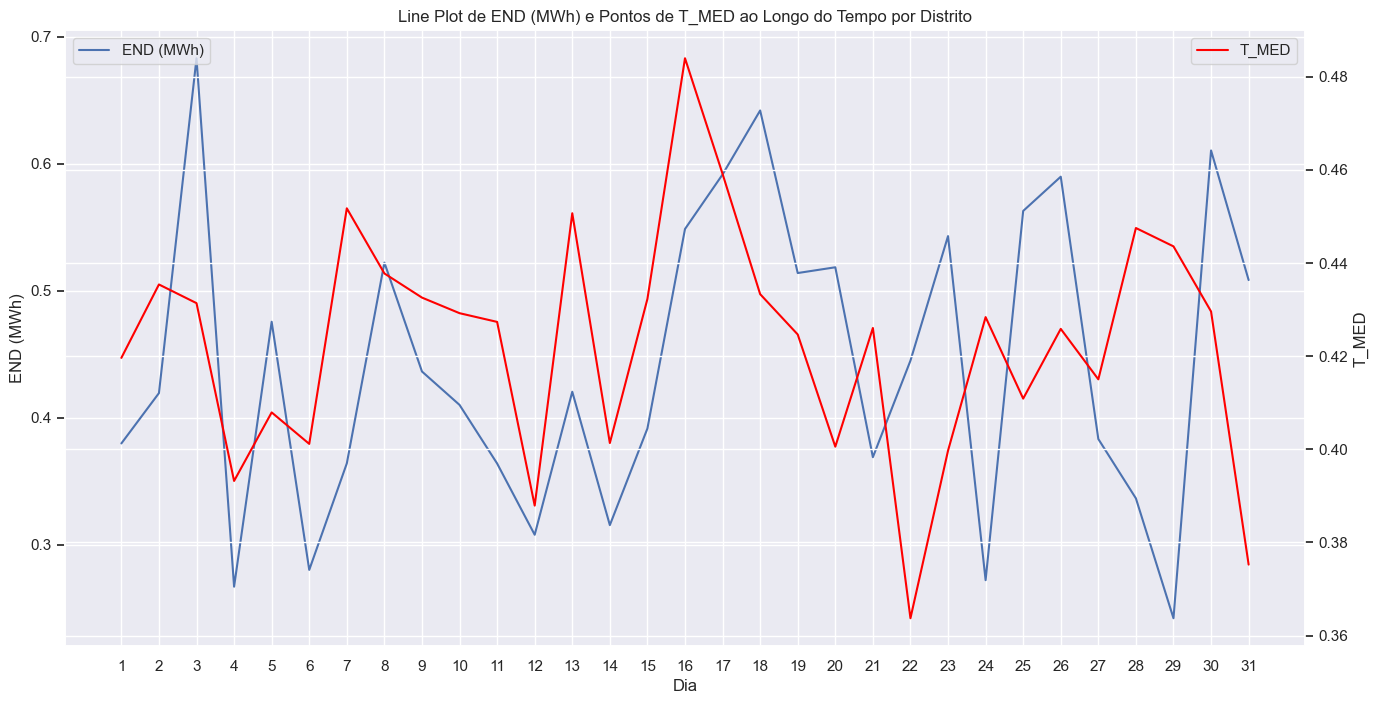

In [50]:
# Converter 'Dia' para numérico
Visualizar['Dia'] = Visualizar['Dia'].astype(int)

# Obter todos os dias do intervalo
todos_os_dias = range(Visualizar['Dia'].min(), Visualizar['Dia'].max() + 1)

if TT == "BT":
    variaveis = ['SAIFI BT (#)', 'SAIDI BT (min)']
else:
    variaveis = ["TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)", "END (MWh)"]

# Definir o estilo do Seaborn
sns.set_style("darkgrid")
tips = sns.load_dataset('tips')
sns.set_context('notebook', font_scale = 1)

IPMA = "T_MED"

# Loop sobre as variáveis
for i in variaveis:
    # Criar o line plot para 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)'
    plt.figure(figsize=(16, 8))
    ax1 = sns.lineplot(data=Visualizar, x='Dia', y=i, label=i, dashes=False, markers=True)

    # Adicionar legenda à esquerda
    plt.legend(loc='upper left')
    
    # Adicionar pontos para 'T_MED' em cada dia
    ax2 = ax1.twinx()
    sns.lineplot(data=Visualizar, x='Dia', y=IPMA, color='red', ax=ax2, label=IPMA)

    # Definir todos os dias no eixo x
    plt.xticks(todos_os_dias)
    
    # Adicionar título e etiquetas dos eixos
    plt.title(f'Line Plot de {i} e Pontos de {IPMA} ao Longo do Tempo por Distrito')
    ax1.set_xlabel('Dia')
    ax1.set_ylabel(i)
    ax2.set_ylabel(IPMA)
    
    # Mostrar o gráfico
    plt.show()


In [28]:
QuebrasFinal[QuebrasFinal["Causa do incidente"]=="Furtos"]

Código do Relatório             Concelho Data do incidente  \
365     EDPD_2018_AGO_T_19            Mangualde        2018-08-17   
707   EREDES_2021_MAR_T_38               Golegã        2021-03-12   
825    EREDES_2021_JUN_T_7             Amarante        2021-06-11   
857   EREDES_2021_JUN_T_39           Felgueiras        2021-06-25   
878    EREDES_2021_JUL_T_8   Marco De Canaveses        2021-07-04   
900   EREDES_2021_JUL_T_30             Abrantes        2021-07-20   
905   EREDES_2021_JUL_T_35                Braga        2021-07-27   
923   EREDES_2021_AGO_T_13                Braga        2021-08-09   
924   EREDES_2021_AGO_T_14            Guimarães        2021-08-10   
927   EREDES_2021_AGO_T_17             Amarante        2021-08-11   
933   EREDES_2021_AGO_T_23               Aveiro        2021-08-14   
935   EREDES_2021_AGO_T_25                Braga        2021-08-21   
946   EREDES_2021_AGO_T_36            Guimarães        2021-08-23   
968   EREDES_2021_SET_T_18             Amarante        2021-09-08   
985   EREDES_2021_SET_T_35            Guimarães        2021-09-23   
995   EREDES_2021_SET_T_45               Amares        2021-09-30   
1005   EREDES_2021_OUT_T_8   Marco De Canaveses        2021-10-06   
1040   EREDES_2021_NOV_T_3             Amarante        2021-11-05   
1044   EREDES_2021_NOV_T_7             Amarante        2021-11-08   
1048  EREDES_2021_NOV_T_11               Sintra        2021-11-16   
1066   EREDES_2021_DEZ_T_3             Amarante        2021-12-07   
1100  EREDES_2022_JAN_T_13                Braga        2022-01-10   
1115  EREDES_2022_JAN_T_28   Marco De Canaveses        2022-01-24   
1129  EREDES_2022_FEV_T_11               Loures        2022-02-12   
1209  EREDES_2022_MAR_T_65                 Seia        2022-03-28   
1290   EREDES_2022_JUN_T_9  São João Da Madeira        2022-06-05   
1355  EREDES_2022_JUL_T_34             Amarante        2022-07-19   
1361  EREDES_2022_JUL_T_40             Sesimbra        2022-07-18   
1402  EREDES_2022_AGO_T_35             Amarante        2022-08-22   
1406  EREDES_2022_AGO_T_39                Braga        2022-08-26   
1408  EREDES_2022_AGO_T_41             Amarante        2022-08-31   
1438  EREDES_2022_SET_T_28     Póvoa De Lanhoso        2022-09-28   
1451   EREDES_2022_OUT_T_7               Lisboa        2022-10-14   
1452   EREDES_2022_OUT_T_8               Lisboa        2022-10-14   
1461  EREDES_2022_OUT_T_17           Felgueiras        2022-10-25   
1467  EREDES_2022_OUT_T_23           Felgueiras        2022-10-24   
1491  EREDES_2022_NOV_T_21                 Fafe        2022-11-18   
1518  EREDES_2022_DEZ_T_16            Guimarães        2022-12-20   
1539    EDPD_2019_JAN_T_11          Santo Tirso        2019-01-09   
1761    EDPD_2019_MAI_T_41               Pombal        2019-05-24   
1905    EDPD_2019_AGO_T_25               Leiria        2019-08-19   
1956    EDPD_2019_OUT_T_26              Tondela        2019-10-22   
1977    EDPD_2019_NOV_T_25               Nazaré        2019-11-27   
2202     EDPD_2020_MAI_T_9                 Faro        2020-05-07   
2265    EDPD_2020_JUN_T_27               Golegã        2020-06-21   
2393    EDPD_2020_SET_T_26             Chamusca        2020-09-18   
2458    EDPD_2020_NOV_T_12               Fundão        2020-11-05   
5188   EDPD_2016_JAN_T_009               Leiria        2016-01-27   
5189   EDPD_2016_JAN_T_010             Alcobaça        2016-01-29   
5231   EDPD_2016_JAN_T_052               Sousel        2016-01-27   
5339   EDPD_2016_MAR_T_013                Moita        2016-03-04   
5821   EDPD_2016_AGO_T_016       Marinha Grande        2016-08-10   
5822   EDPD_2016_AGO_T_017       Marinha Grande        2016-08-10   
6607    EDPD_2017_ABR_T_23             Abrantes        2017-04-30   
7123    EDPD_2017_SET_T_88             Alcobaça        2017-09-15   
7124    EDPD_2017_SET_T_89             Alcobaça        2017-09-29   
7261    EDPD_2017_NOV_T_11             Alcobaça        2017-11-03   

    

In [29]:
QuebrasFinal["Causa do incidente"].unique()

array(['Escavações', 'Abate De Árvores', 'Deslizamento De Terras', 'Aves',
       'Animais Não Aves', 'Malfeitoria/Vandalismo', 'Veículos',
       'Terramoto', 'Neve/Gelo/Granizo Condição Excecional',
       'Corpos Estranhos Na Rede', 'Vento Intensidade Excepcional',
       'Descarga Atmosférica Directa', 'Intervenções À Superficie',
       'Inundações Imprevisíveis', 'Risco Iminente Pessoas Ou Bens',
       'Incêndio', 'Furtos', 'Sabotagem',
       'Desabamento De Muros/Outras Cons',
       'Desabamento De Muros/Outras Construções',
       'Trabalhos De Terceiros ( Gruas,... )'], dtype=object)

- - -

In [30]:
file = data_folder / "AllDaysEventos.parquet"
QuebrasFinal = pd.read_parquet(file)
QuebrasFinal

Data do incidente               Concelho Distrito  \
0              2014-01-01     Albergaria-A-Velha   Aveiro   
1              2014-01-01                 Anadia   Aveiro   
2              2014-01-01                 Arouca   Aveiro   
3              2014-01-01                 Aveiro   Aveiro   
4              2014-01-01       Castelo De Paiva   Aveiro   
...                   ...                    ...      ...   
1008000        2023-12-31  Reguengos De Monsaraz    Évora   
1008001        2023-12-31           Vendas Novas    Évora   
1008002        2023-12-31      Viana Do Alentejo    Évora   
1008003        2023-12-31            Vila Viçosa    Évora   
1008004        2023-12-31                  Évora    Évora   

                 Nível de Tensão  Número de Eventos  Dia  Mês   Ano  \
0        Sem Eventos Excecionais                  0    1    1  2014   
1        Sem Eventos Excecionais                  0    1    1  2014   
2        Sem Eventos Excecionais                  0    1    1  2014   
3        Sem Eventos Excecionais                  0    1    1  2014   
4        Sem Eventos Excecionais                  0    1    1  2014   
...                          ...                ...  ...  ...   ...   
1008000  Sem Eventos Excecionais                  0   31   12  2023   
1008001  Sem Eventos Excecionais                  0   31   12  2023   
1008002  Sem Eventos Excecionais                  0   31   12  2023   
1008003  Sem Eventos Excecionais                  0   31   12  2023   
1008004  Sem Eventos Excecionais                  0   31   12  2023   

         Densidade Populacional  População Residente  ...  \
0                         157.7              25053.0  ...   
1                         131.0              28378.0  ...   
2                          66.3              21815.0  ...   
3                         400.3              79092.0  ...   
4                         141.5              16275.0  ...   
...                         ...                  ...  ...   
1008000                    21.2               9836.0  ...   
1008001                    51.2              11394.0  ...   
1008002                    13.9               5470.0  ...   
1008003                    37.7               7349.0  ...   
1008004                    41.1              53753.0  ...   

         Indice de Envelhecimento  Rural  T_MED  T_MAX  T_MIN  DD_MED  DD_FFX  \
0                           132.3   1.00   13.9   15.1   12.6   194.0   225.0   
1                           209.7   1.00   13.9   15.1   12.6   194.0   225.0   
2                           130.5   1.00   13.9   15.1   12.6   194.0   225.0   
3                           124.7   0.00   13.9   15.1   12.6   194.0   225.0   
4                           110.9   1.00   13.9   15.1   12.6   194.0   225.0   
...                           ...    ...    ...    ...    ...     ...     ...   
1008000                     208.9   1.00   10.6   13.5    6.8   275.0   339.0   
1008001                     240.6   1.00   10.6   13.5    6.8   275.0   339.0   
1008002                     197.7   1.00   10.6   13.5    6.8   275.0   339.0   
1008003                     238.9   1.00   10.6   13.5    6.8   275.0   339.0   
1008004                     178.5   0.75   10.6   13.5    6.8   275.0   339.0   

         FF_MED  FF_MAX  PR_QTD  
0           4.3    15.4    16.2  
1           4.3    15.4    16.2  
2           4.3    15.4    16.2  
3           4.3    15.4    16.2  
4           4.3    15.4    16.2  
...         ...     ...     ...  
1008000     1.6     7.0     1.1  
1008001     1.6     7.0     1.1  
1008002     1.6     7.0     1.1  
1008003     1.6     7.0     1.1  
1008004     1.6     7.0     1.1  

[1008005 rows x 23 columns]

In [31]:
Concelho = 'Lisboa'

BT = QuebrasFinal[(QuebrasFinal["Distrito"] == Concelho) & (QuebrasFinal["Ano"] == 2018)]
BT = BT_grouped = BT.groupby(['Data do incidente', 'Dia', 'Mês', 'Ano', 
                               'T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']).agg({'Número de Eventos': 'sum'}).reset_index()

# Não está a dar os 365 dias não sei porquê
BT

Data do incidente  Dia  Mês   Ano  T_MED  T_MAX  T_MIN  DD_MED  DD_FFX  \
0          2018-01-01    1    1  2018   12.0   16.3    8.1   277.0   270.0   
1          2018-01-02    2    1  2018   13.0   15.9    9.1   269.0   309.0   
2          2018-01-03    3    1  2018   14.5   17.0   12.9   284.0   309.0   
3          2018-01-04    4    1  2018   14.3   16.3   13.3   251.0   264.0   
4          2018-01-05    5    1  2018   12.4   15.1    9.1   288.0   225.0   
..                ...  ...  ...   ...    ...    ...    ...     ...     ...   
355        2018-12-27   27   12  2018   10.9   14.3    8.1    49.0   321.0   
356        2018-12-28   28   12  2018   13.8   17.3   10.3    18.0   354.0   
357        2018-12-29   29   12  2018   11.0   15.1    8.0    54.0    79.0   
358        2018-12-30   30   12  2018   11.0   15.8    7.8    53.0    51.0   
359        2018-12-31   31   12  2018   10.3   15.0    6.9    53.0    51.0   

     FF_MED  FF_MAX  PR_QTD  Número de Eventos  
0       1.5     7.0     0.0                  0  
1       1.8     6.9     0.0                  0  
2       2.1     6.0     0.1                  0  
3       2.8     7.9     0.8                  0  
4       3.6    13.9    13.2                  1  
..      ...     ...     ...                ...  
355     1.2     4.7     0.1                  0  
356     2.2     7.6     0.0                  0  
357     4.3     9.3     0.0                  0  
358     4.5    10.2     0.0                  0  
359     2.7     6.3     0.0                  0  

[360 rows x 13 columns]

In [32]:
def existeEvento(x):
    if x > 0:
        return 1
    else:
        return 0

BT["HouveEventos?"] = BT["Número de Eventos"].apply(existeEvento)
BT.drop('Número de Eventos', axis = 1, inplace=True)
BT

Data do incidente  Dia  Mês   Ano  T_MED  T_MAX  T_MIN  DD_MED  DD_FFX  \
0          2018-01-01    1    1  2018   12.0   16.3    8.1   277.0   270.0   
1          2018-01-02    2    1  2018   13.0   15.9    9.1   269.0   309.0   
2          2018-01-03    3    1  2018   14.5   17.0   12.9   284.0   309.0   
3          2018-01-04    4    1  2018   14.3   16.3   13.3   251.0   264.0   
4          2018-01-05    5    1  2018   12.4   15.1    9.1   288.0   225.0   
..                ...  ...  ...   ...    ...    ...    ...     ...     ...   
355        2018-12-27   27   12  2018   10.9   14.3    8.1    49.0   321.0   
356        2018-12-28   28   12  2018   13.8   17.3   10.3    18.0   354.0   
357        2018-12-29   29   12  2018   11.0   15.1    8.0    54.0    79.0   
358        2018-12-30   30   12  2018   11.0   15.8    7.8    53.0    51.0   
359        2018-12-31   31   12  2018   10.3   15.0    6.9    53.0    51.0   

     FF_MED  FF_MAX  PR_QTD  HouveEventos?  
0       1.5     7.0     0.0              0  
1       1.8     6.9     0.0              0  
2       2.1     6.0     0.1              0  
3       2.8     7.9     0.8              0  
4       3.6    13.9    13.2              1  
..      ...     ...     ...            ...  
355     1.2     4.7     0.1              0  
356     2.2     7.6     0.0              0  
357     4.3     9.3     0.0              0  
358     4.5    10.2     0.0              0  
359     2.7     6.3     0.0              0  

[360 rows x 13 columns]

In [33]:
BT["Dia"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

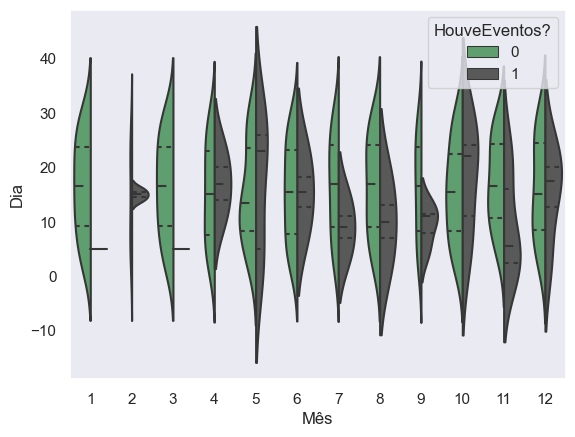

In [37]:
sns.set_theme(style="dark")

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=BT, x="Mês", y="Dia", hue="HouveEventos?",
               split=True, inner="quart", fill=False,
               palette={0: "g", 1: ".35"})

# Salve a figura
plt.savefig('violinplotHaverEventos.png')

plt.show()

C:\Users\diogo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


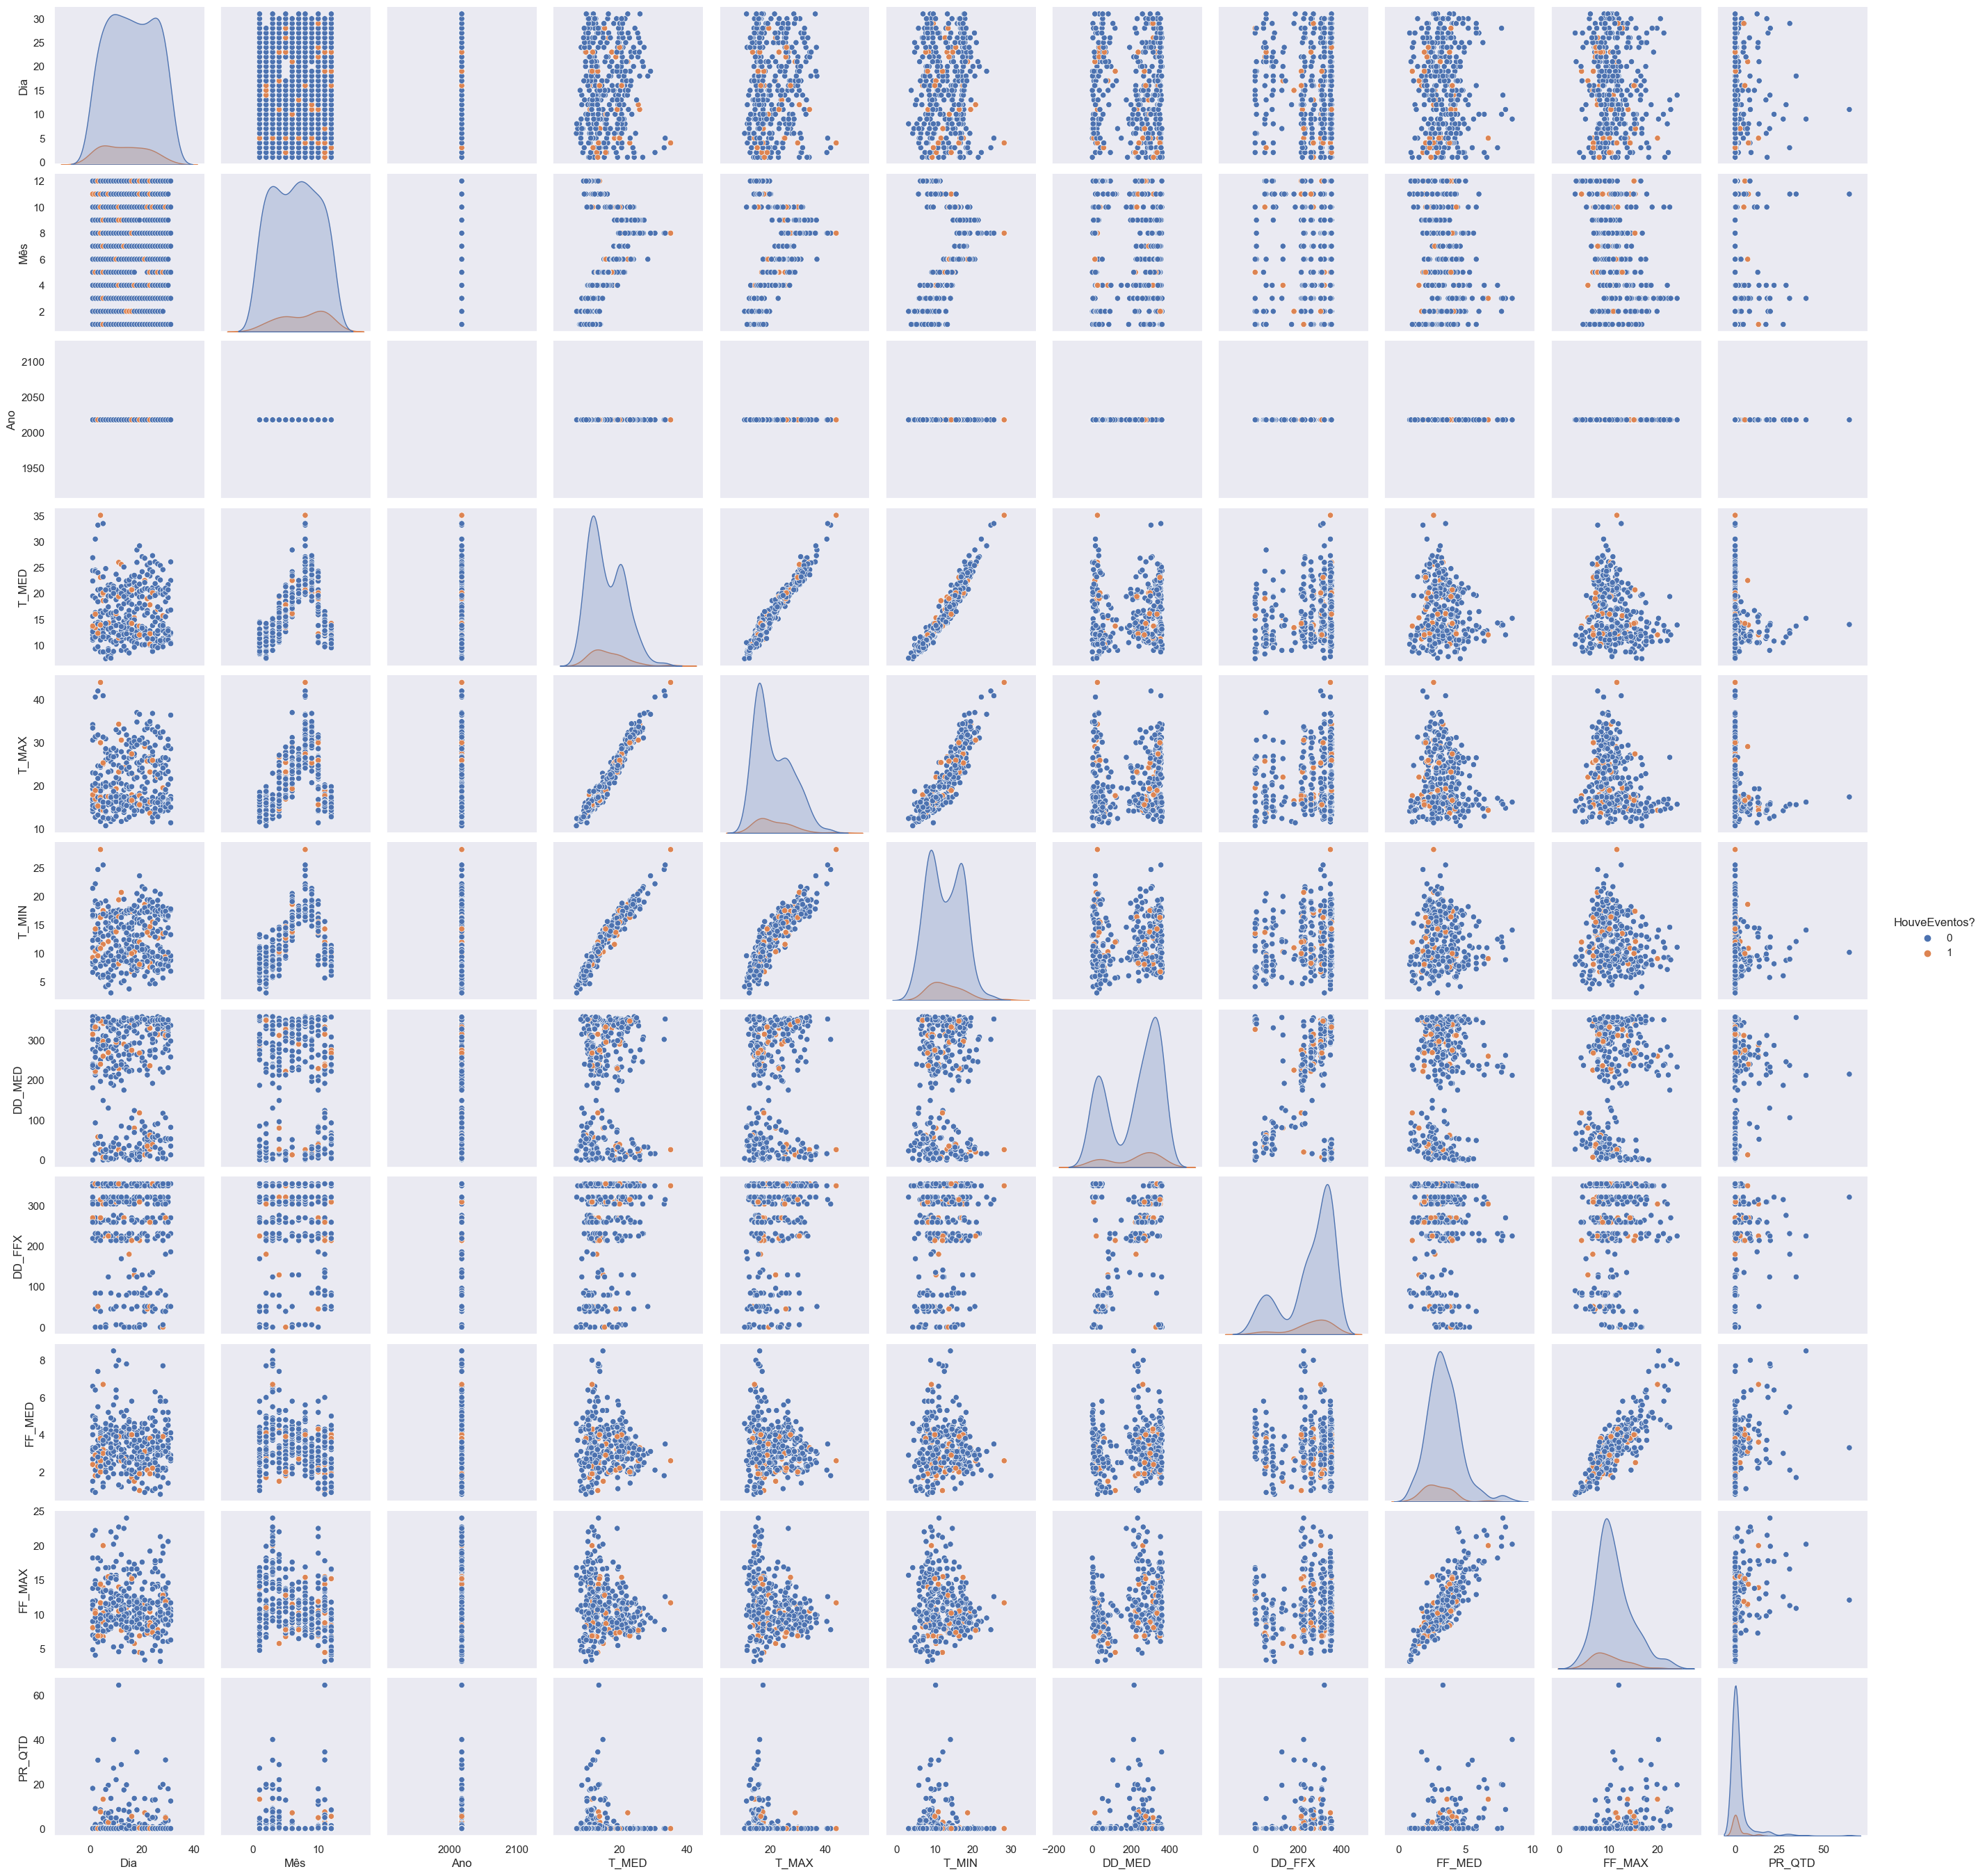

In [38]:
sns.pairplot(BT, hue="HouveEventos?")

plt.savefig('pairplot.png')

plt.show()